In [1]:
import pandas as pd  # For working with data in tabular format
import numpy as np  # For numerical computations
import matplotlib.pyplot as plt  # For creating plots and visualizations
from matplotlib_venn import venn2  # For creating Venn diagrams
import plotly.express as px  # For interactive visualizations
import os  # For folder generation
import statistics  # For statistical computations

The next cell is tailored specifically for handling and combining _ion_label_quant.tsv output files from FragPipe. 
If you have a different single output file format, you can load and process it in the cell below.

In [2]:
#170123_Eddy_TAILS-1_10_ST_GA9_01_1465, 170123_Eddy_TAILS-2_10_ST_GA10_01_1466, 170123_Eddy_TAILS-3_10_ST_GA11_01_1464, 170119_Eddy_TAILS-1_10_ST_GA9_01_1415, 170119_Eddy_TAILS-2_10_ST_GA10_01_1416, 
#170119_Eddy_TAILS-3_10_ST_GA11_01_1417
file_prefixes_input = input('Enter the file prefixes, before "_ion_label_quant.tsv", separated by commas: ').strip().split(',')
file_prefixes = [prefix.strip() for prefix in file_prefixes_input]


directory = input("Enter the directory to save intermediate files (default: 'intermediate_files'): ").strip()
if not directory:
    directory = 'intermediate_files'
if not os.path.exists(directory):
    os.makedirs(directory)

def main():
    global directory

    # Processing and aggregating data for each file prefix
    for prefix in file_prefixes:
        try:
            # Read the original file using pandas read_csv function
            df = pd.read_csv(f"{prefix}_ion_label_quant.tsv", sep='\t')
        except FileNotFoundError:
            print(f"File not found: {prefix}_ion_label_quant.tsv")
            continue

        # Combine the same peptides with different charge states and possible oxidation on methionine
        df['Modified Peptide'] = df['Modified Peptide'].str.replace(r'\[15\.9949\]', '', regex=True)

        # Group the DataFrame by specified columns and sum the intensity columns
        grouped_df = df.groupby(['Peptide Sequence', 'Modified Peptide', 'Peptide Length', 'Protein ID', 'Protein Description', 'Label Count']).agg({
            'Light Intensity': 'sum',  # Sum the 'Light Intensity' column
            'Heavy Intensity': 'sum'   # Sum the 'Heavy Intensity' column
        }).reset_index()  # Reset the index of the resulting DataFrame

        # Replace 0 values with NaN in intensity columns
        columns_to_replace = ['Light Intensity', 'Heavy Intensity']
        grouped_df[columns_to_replace] = grouped_df[columns_to_replace].replace(0, np.nan)

        # Calculate log2 ratios of 'Heavy Intensity' divided by 'Light Intensity'
        grouped_df['Log2 Ratio HL_new'] = np.log2(grouped_df['Heavy Intensity'] / grouped_df['Light Intensity'])

        # Define the file path for saving
        file_path = os.path.join(directory, f"{prefix}_df_max_label_count_newlog2.tsv")

        # Save the updated DataFrame to a new file with a modified file prefix
        grouped_df.to_csv(file_path, sep='\t', index=False)

        # Notify the user about the saved file
        print(f"Processed and saved: {file_path}")

if __name__ == "__main__":
    main()

# Create an empty list to store DataFrames
dfs = []

# Iterate over each file prefix
for prefix in file_prefixes:
    file_path = os.path.join(directory, f"{prefix}_df_max_label_count_newlog2.tsv")  # Construct the file path

    # Read the file
    df = pd.read_csv(file_path, sep='\t')

    # Select specific columns
    df = df[['Peptide Sequence', 'Modified Peptide', 'Peptide Length', 'Protein ID', 'Protein Description', 'Label Count']]

    # Append the DataFrame to the list of DataFrames
    dfs.append(df)

# Combine entries with the same "Modified Peptide", "Protein ID", and "Charge"
combined_df = pd.concat(dfs).drop_duplicates()

def process_ion_label_quant(df, prefix):
    # Select specific columns from the dataframe
    df = df[['Log2 Ratio HL_new', 'Modified Peptide', 'Protein ID', 'Label Count', 'Light Intensity', 'Heavy Intensity']].copy()

    # Rename columns based on the provided prefix
    df = df.rename(columns={
        'Log2 Ratio HL_new': f'Log2 Ratio HL_new {prefix}',
        'Light Intensity': f'Light Intensity {prefix}',
        'Heavy Intensity': f'Heavy Intensity {prefix}',
        'Modified Peptide': f'Modified Peptide {prefix}'})

    return df

# Define a function to merge dataframes based on specific columns
def merge_dfs(combined_df, df, prefix):
    # Merge dataframes on specified columns and drop redundant columns
    merged_df = pd.merge(combined_df, df,
                         left_on=['Modified Peptide', 'Protein ID', 'Label Count'],
                         right_on=[f'Modified Peptide {prefix}', 'Protein ID', 'Label Count'],
                         how='left')
    return merged_df.drop([f'Modified Peptide {prefix}'], axis=1)

# Loop through each file prefix
for prefix in file_prefixes:
    # Read ion label quant data from file
    ion_label_quant_df = pd.read_csv(os.path.join(directory, f"{prefix}_df_max_label_count_newlog2.tsv"), sep='\t')
    # Print the number of peptides in the dataframe
    print(f"{len(ion_label_quant_df)} Anzahl der Peptide in {prefix}_df_max_label_count_newlog2")

    # Process ion label quant data and rename columns
    processed_df = process_ion_label_quant(ion_label_quant_df, prefix)

    # Merge dataframes based on specific columns
    combined_df = merge_dfs(combined_df, processed_df, prefix)

# Define a custom aggregation function to keep the row with the maximum "Label Count"
def keep_max_label_count(rows):
    # Find the index of the row with the maximum "Label Count"
    max_label_count_index = rows['Label Count'].idxmax()
    # Return the entire row corresponding to the maximum "Label Count"
    return rows.loc[max_label_count_index]

# Apply the custom aggregation function to keep the row with the maximum "Label Count" for each group
combined_df_max_label_count = combined_df.groupby(['Peptide Sequence', 'Modified Peptide', 'Peptide Length', 'Protein ID', 'Protein Description']).apply(keep_max_label_count).reset_index(drop=True)

# Print the number of peptides in the final combined dataframe
print(f"{len(combined_df_max_label_count)} Peptide combined_df_max_label_count")

Enter the file prefixes, before "_ion_label_quant.tsv", separated by commas: 170123_Eddy_TAILS-1_10_ST_GA9_01_1465, 170123_Eddy_TAILS-2_10_ST_GA10_01_1466, 170123_Eddy_TAILS-3_10_ST_GA11_01_1464
Enter the directory to save intermediate files (default: 'intermediate_files'): 
Processed and saved: intermediate_files/170123_Eddy_TAILS-1_10_ST_GA9_01_1465_df_max_label_count_newlog2.tsv
Processed and saved: intermediate_files/170123_Eddy_TAILS-2_10_ST_GA10_01_1466_df_max_label_count_newlog2.tsv
Processed and saved: intermediate_files/170123_Eddy_TAILS-3_10_ST_GA11_01_1464_df_max_label_count_newlog2.tsv
1375 Anzahl der Peptide in 170123_Eddy_TAILS-1_10_ST_GA9_01_1465_df_max_label_count_newlog2
1544 Anzahl der Peptide in 170123_Eddy_TAILS-2_10_ST_GA10_01_1466_df_max_label_count_newlog2
1747 Anzahl der Peptide in 170123_Eddy_TAILS-3_10_ST_GA11_01_1464_df_max_label_count_newlog2
2243 Peptide combined_df_max_label_count


Start here if you already have a file containing different replicates, which is the case when MBR is enabled and there are no technical replicates. Change this part of the code: "pd.read_csv(f"{prefix}_ion_label_quant.tsv", sep='\t')" but you need to work with a prefix to be able to run the other cells. 
Click on the next cell, select "Cell" in the bar, then "Cell type" and "Code"

In [6]:
# Removal of pyro_glu and loss of ammonia on Cys
default_substrings = "-17.0266,-18.0106"

# Get user input and use default values if the input is empty
substrings_input = input(f"Enter pyro_Glu modifications in 'Modified Peptide', separated by commas (default: {default_substrings}): ").strip()
substrings = substrings_input.split(',') if substrings_input else default_substrings.split(',')

# Create a boolean mask for rows that do not contain any of the specified substrings in'Modified Peptide'
mask = ~combined_df_max_label_count['Modified Peptide'].str.contains('|'.join(substrings), case=False, na=False)

# Apply the mask to get a subset of the DataFrame
combined_df_without_pyro = combined_df_max_label_count[mask].copy()

# Print the number of peptides without the specified substrings in 'Modified Peptide'
print(f"{len(combined_df_without_pyro)} Peptides without pyro-Glu\n")

# Reset the index of the DataFrame
combined_df_without_pyro = combined_df_without_pyro.reset_index(drop=True)

Enter pyro_Glu modifications in 'Modified Peptide', separated by commas (default: -17.0266,-18.0106): 
2131 Peptides without pyro-Glu



Normally this cell is not needed and just used for the reanalyis of a part of the published TAILS N-terminome dataset (Hofsetz et al., 2020).
Only execute this cell, if you have technical replicates of biological replicates 
and you want to combine the intensities, otherwise skip it. This may be the case for ion_label_quant.tsv files

In [5]:
file_prefixes = [
    '170123_Eddy_TAILS-1_10_ST_GA9_01_1465', '170119_Eddy_TAILS-1_10_ST_GA9_01_1415',
    '170123_Eddy_TAILS-2_10_ST_GA10_01_1466', '170119_Eddy_TAILS-2_10_ST_GA10_01_1416',
    '170123_Eddy_TAILS-3_10_ST_GA11_01_1464', '170119_Eddy_TAILS-3_10_ST_GA11_01_1417'
]


# Drop specific 'Log2 Ratio' columns
log2_ratio_columns_to_drop = [f'Log2 Ratio HL_new {prefix}' for prefix in file_prefixes]
combined_df_without_pyro = combined_df_without_pyro.drop(log2_ratio_columns_to_drop, axis=1, errors='ignore')

# Define a function to combine intensities for a specific prefix
def combine_intensities(df, prefix1, prefix2, prefix_name):
    # Combine intensities for Light and Heavy
    df[f'Light Intensity {prefix_name}_combined'] = df[f'Light Intensity {prefix1}'] + df[f'Light Intensity {prefix2}']
    df[f'Heavy Intensity {prefix_name}_combined'] = df[f'Heavy Intensity {prefix1}'] + df[f'Heavy Intensity {prefix2}']
    
    # Remove original Light and Heavy Intensity columns
    df.drop([f'Light Intensity {prefix1}', f'Light Intensity {prefix2}', f'Heavy Intensity {prefix1}', f'Heavy Intensity {prefix2}'], axis=1, inplace=True)
    
    return df

# Use prefixes to combine intensities
for i in range(0, len(file_prefixes), 2):
    combined_df_without_pyro = combine_intensities(combined_df_without_pyro, file_prefixes[i], file_prefixes[i+1], f'TAILS{(i//2)+1}')

# Define a function to calculate log2 ratios for a specific prefix
def calculate_log2_ratios(df, prefix):
    # Calculate log2 ratios for the specified intensities
    columns_to_replace = [f'Light Intensity {prefix}', f'Heavy Intensity {prefix}']
    df[columns_to_replace] = df[columns_to_replace].replace(0, np.nan)
    df[f'Log2 Ratio {prefix} Heavy/Light'] = np.log2(df[f'Heavy Intensity {prefix}'] / df[f'Light Intensity {prefix}'])
    
    return df

# Use combined prefixes to calculate log2 ratios
combined_prefixes = [f'TAILS{i+1}_combined' for i in range(len(file_prefixes)//2)]
for prefix in combined_prefixes:
    combined_df_without_pyro = calculate_log2_ratios(combined_df_without_pyro, prefix)

display(combined_df_without_pyro)


IndexError: list index out of range

Please enter the path of the tsv file originating from the organism specific FASTA file (e.g., Mus_musculus_Mouse_canonical_2024_03_06.tsv): Mus_musculus_Mouse_canonical_2024_03_06.tsv


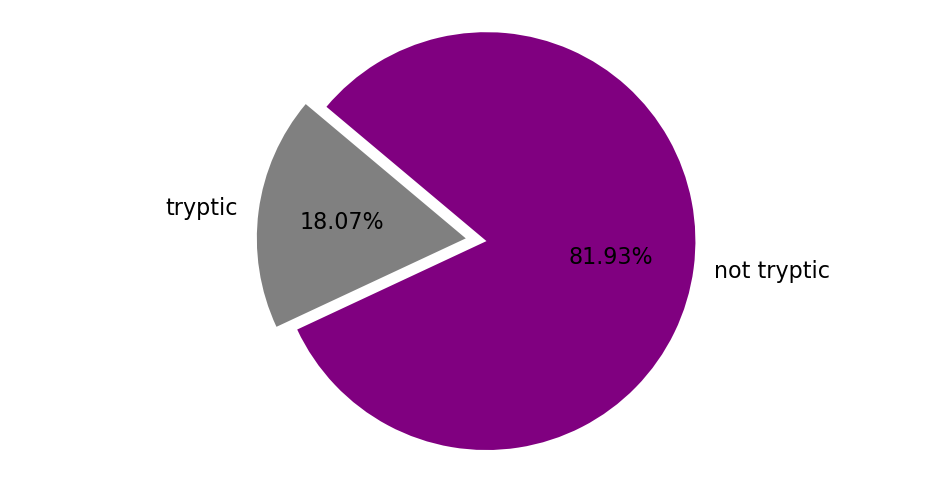

In [7]:
# This is necessary if using isoforms
# combined_df_without_pyro['Protein ID'] = combined_df_without_pyro['Protein ID'].str.split('-').str[0]

# Create a directory for storing figures if it doesn't exist
figures_dir = "Figures"
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)

# Merge with fasta file
fasta_file = input("Please enter the path of the tsv file originating from the organism specific FASTA file (e.g., Mus_musculus_Mouse_canonical_2024_03_06.tsv): ")
while not os.path.exists(fasta_file):
    print("File not found. Please enter a valid file path.")
    fasta_file = input("Please enter the path to the FASTA file (e.g., Mus_musculus_Mouse_canonical_2024_03_06.tsv): ")

# Read in the fasta file
fasta_df = pd.read_csv(fasta_file, sep='\t')

# Select the 'seq' column from gene_info_df
gene_seq_df = fasta_df[['Protein Id', 'seq']]

# Merge dataframes based on 'Protein ID'
combined_df_without_pyro_fasta = pd.merge(combined_df_without_pyro, gene_seq_df, left_on='Protein ID', right_on='Protein Id', how='inner')

# Find the position of 'Peptide Sequence' in 'seq' and calculate start and end positions
combined_df_without_pyro_fasta['Start_Position_in_seq-1'] = combined_df_without_pyro_fasta.apply(lambda row: row['seq'].find(row['Peptide Sequence']), axis=1)
combined_df_without_pyro_fasta['Start_Position_in_seq'] = combined_df_without_pyro_fasta['Start_Position_in_seq-1'] + 1
combined_df_without_pyro_fasta['End_Position_in_seq-1'] = combined_df_without_pyro_fasta.apply(lambda row: row['Start_Position_in_seq'] + len(row['Peptide Sequence']), axis=1)
combined_df_without_pyro_fasta['End_Position_in_seq'] = combined_df_without_pyro_fasta['End_Position_in_seq-1'] - 1

# Extract 1 amino acid before 'Peptide Sequence' and create a new column 'Amino_acid_before_Sequence'
combined_df_without_pyro_fasta['Amino_acid_before_Sequence'] = combined_df_without_pyro_fasta.apply(lambda row: row['seq'][row['Start_Position_in_seq-1'] - 1:row['Start_Position_in_seq-1']], axis=1)

# Extract 6 amino acids before 'Peptide Sequence' and create a new column '6_Amino_acids_before_Sequence'
combined_df_without_pyro_fasta['6_Amino_acids_before_Sequence'] = combined_df_without_pyro_fasta.apply(lambda row: row['seq'][row['Start_Position_in_seq-1'] - 6:row['Start_Position_in_seq-1']], axis=1)

# Create a 'cleavage_window' column by concatenating the last 6 characters of '6_Amino_acids_before_Sequence' and the first 6 characters of 'Peptide Sequence'
combined_df_without_pyro_fasta['cleavage_window'] = combined_df_without_pyro_fasta['6_Amino_acids_before_Sequence'].str[-6:] + combined_df_without_pyro_fasta['Peptide Sequence'].astype(str).str[:6]

# Drop unnecessary columns
combined_df_without_pyro_fasta = combined_df_without_pyro_fasta.drop(['End_Position_in_seq-1', 'Start_Position_in_seq-1'], axis=1)

# Counting 'R' and 'K' in the 'Amino_acid_before_Sequence' column to calculate percentage of tryptic peptides
count_R_K = combined_df_without_pyro_fasta['Amino_acid_before_Sequence'].str.count('[RK]')
total_peptides = len(combined_df_without_pyro_fasta)
percentage_R_K = (count_R_K.sum() / total_peptides) * 100
not_tryptic = 100 - percentage_R_K

# Data for the pie chart
labels = ['tryptic', 'not tryptic']
sizes = [percentage_R_K, not_tryptic]
colors = ['grey', 'purple']
explode = (0.1, 0)  # Explode the 1st slice (tryptic peptides)

# Plotting the pie chart
plt.figure(figsize=(12, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.2f%%', startangle=140, textprops={'fontsize': 16, 'color': 'black'})
#plt.pie(sizes, explode=explode, colors=colors, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Saving the pie chart
plt.savefig("Figures/Tryptic_pie.pdf", dpi=600)

# Showing the pie chart
plt.show()

In [8]:
# merge with targetp2 file
# Read in the fasta file converted in script 2
df_targetp2 = pd.read_csv("./mouse_summary_modified.targetp2", sep='\t')

# Merge dataframes 'Log2_ratio_mean_fasta' and 'df_targetp2' based on 'Protein ID' and 'ID'
targetp2_merged_df = pd.merge(combined_df_without_pyro_fasta, df_targetp2, left_on='Protein ID', right_on='# ID', how='left')

# Extract the number between "CS pos:" and "-" from the 'Combined_CS' column
targetp2_merged_df['Start_Position_targetp2'] = targetp2_merged_df['Combined_CS'].str.extract(r'CS pos: \d+-(\d+)\.')

# Convert the extracted number to numeric type, handling errors by converting them to NaN
targetp2_merged_df['Start_Position_targetp2'] = pd.to_numeric(targetp2_merged_df['Start_Position_targetp2'], errors='coerce')

# Create a new column 'Start_targetp2_equal_Start_observed' based on the condition
targetp2_merged_df['Start_targetp2_equal_Start_observed'] = np.where(
    targetp2_merged_df['Start_Position_targetp2'] == targetp2_merged_df['Start_Position_in_seq'],
    True, False)

# Remove entries where 'Start_Position_in_seq' is 0, as the sequence does not belong to the Protein
targetp2_merged_df = targetp2_merged_df[targetp2_merged_df['Start_Position_in_seq'] != 0]

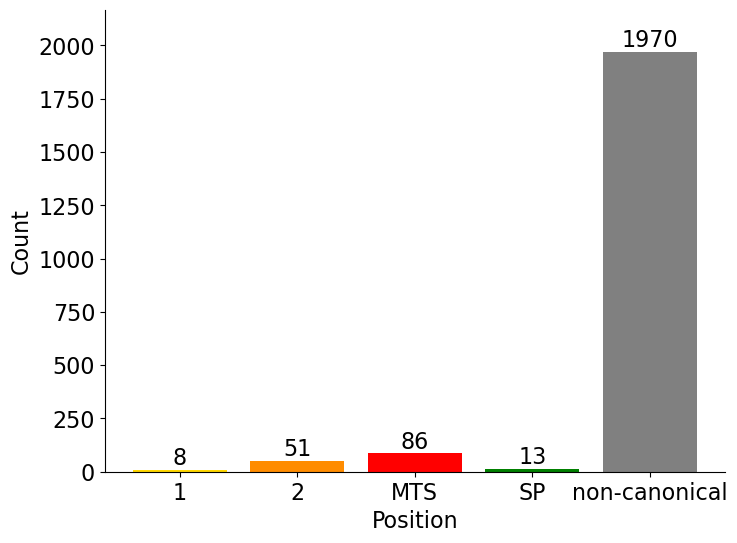

In [9]:
# Create a directory for storing figures if it doesn't exist
figures_dir = "Figures"
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)

# Filter DataFrame for rows where 'Start_Position_in_seq' is 1
filtered_df = targetp2_merged_df[targetp2_merged_df['Start_Position_in_seq'].isin([1])]

# Count the occurrences of each value in 'Start_Position_in_seq'
value_counts1 = filtered_df['Start_Position_in_seq'].value_counts()

# Filter DataFrame for rows where 'Start_Position_in_seq' is 2
filtered_df2 = targetp2_merged_df[targetp2_merged_df['Start_Position_in_seq'].isin([2])]

# Count the occurrences of each value in 'Start_Position_in_seq'
value_counts2 = filtered_df2['Start_Position_in_seq'].value_counts()

# Check if 'True' in 'Start_targetp2_equal_Start_observed' and 'MT' in 'Prediction'
mt_counts = targetp2_merged_df[(targetp2_merged_df['Start_targetp2_equal_Start_observed'] == True) & (targetp2_merged_df['Prediction'] == 'MT')].shape[0]

# Check if 'True' in 'Start_targetp2_equal_Start_observed' and 'SP' in 'Prediction'
sp_counts = targetp2_merged_df[(targetp2_merged_df['Start_targetp2_equal_Start_observed'] == True) & (targetp2_merged_df['Prediction'] == 'SP')].shape[0]

# Calculate the count for the remaining values ('NoN')
non_counts = ((len(targetp2_merged_df) - (value_counts1.sum() + value_counts2.sum() + mt_counts + sp_counts)))

# Create a list of values for plotting the bar chart
bar_values = [value_counts1.get(1, 0), value_counts2.get(2, 0), mt_counts, sp_counts, non_counts]

# Plotting the bar chart
# Plotting the bar chart
fig, ax = plt.subplots(figsize=(8, 6))
bar_labels = ["1", "2", 'MTS', 'SP', 'non-canonical']

# Define colors for the bars
colors = ["#FFD700", "#FF8C00", 'red', 'green', 'gray']

# Create bars with corresponding labels and colors
bars = ax.bar(bar_labels, bar_values, color=colors)

# Set chart title, x-axis label, and y-axis label
plt.ylabel('Count', fontsize = 16)
plt.xlabel('Position', fontsize = 16)

# Set ylim for y-axis
plt.ylim(0, max(bar_values) * 1.1)  # Adjust multiplier as needed

# Customize y-axis tick labels
ax.tick_params(axis='y', labelsize=16) 
# Customize x-axis tick labels
ax.tick_params(axis='x', labelsize=16) 

# Remove left spine
ax.spines['right'].set_visible(False)
# Remove top spine
ax.spines['top'].set_visible(False)

# Add text labels on top of the bars indicating the count values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom',fontsize=16)

output_file = os.path.join(figures_dir, "histograms_position.pdf")
plt.savefig(output_file, dpi=600)
# Display the bar chart
plt.show()

In [10]:
# Filter rows where the 'Prediction' column is 'MT'
targetp2_MT_prediction = targetp2_merged_df[targetp2_merged_df["Prediction"] == 'MT']  

# Print the number of peptides matched with targetp2 and 'MT' as Prediction
print(f"{len(targetp2_MT_prediction)} Peptide matched with targetp2 and 'MT' as Prediction")

# Create a new column 'Modification_Status' based on conditions in 'Modified Peptide'
targetp2_MT_prediction['Modification_Status'] = np.where(
    targetp2_MT_prediction['Modified Peptide'].str.contains("42.0106", case=False, na=False),
    'Acetylated', 'Dimethylated')

# Calculate the difference between 'Start_Position_in_seq' and 'Start_Position_targetp2' and create a new column
targetp2_MT_prediction['Position_Difference'] = (
    targetp2_MT_prediction['Start_Position_in_seq'] - 
    targetp2_MT_prediction['Start_Position_targetp2'])

# Create a copy of the DataFrame for further processing
targetp2_MT_prediction_copy = targetp2_MT_prediction.copy()

# Filter rows where the absolute difference between 'Start_Position_targetp2' and 'Start_Position_in_seq' is <= 10
condition = abs(targetp2_MT_prediction_copy['Start_Position_targetp2'] - targetp2_MT_prediction_copy['Start_Position_in_seq']) <= 10

# Create a DataFrame with rows matching the condition
targetp2_MT_prediction_plusminus10_df = targetp2_MT_prediction_copy.loc[condition].copy()
targetp2_MT_prediction_plusminus10_df.reset_index(drop=True, inplace=True)

# Print the number of peptides matched with targetp2 +/- 10 and 'MT' as Prediction
print(f"{len(targetp2_MT_prediction_plusminus10_df)} Peptide matched with targetp2 +/- 10 and 'MT' as Prediction")

1052 Peptide matched with targetp2 and 'MT' as Prediction
235 Peptide matched with targetp2 +/- 10 and 'MT' as Prediction


/var/folders/bz/x13h693d4cqcf71bsncvwy_r0000gn/T/ipykernel_19215/3460460854.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targetp2_MT_prediction['Modification_Status'] = np.where(
/var/folders/bz/x13h693d4cqcf71bsncvwy_r0000gn/T/ipykernel_19215/3460460854.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targetp2_MT_prediction['Position_Difference'] = (


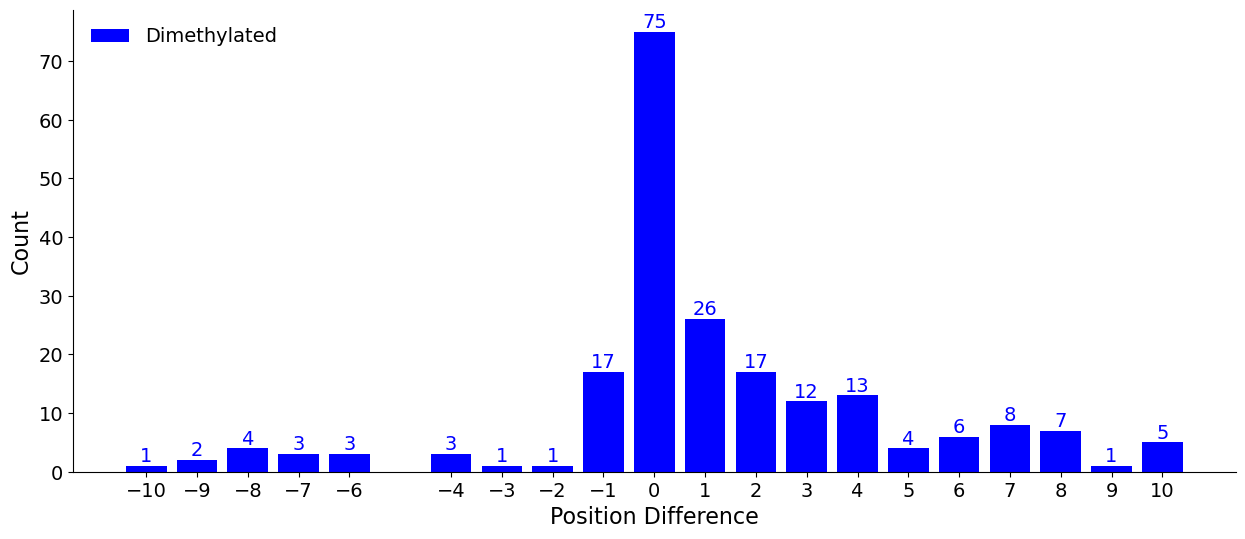

In [11]:
# Create a Series with the complete range of values from -10 to 10 and fill missing values with zeros
full_range = pd.Series(0, index=range(-10, 11))

# Filter entries with "Dimethylated" status
entries_dimethylated = targetp2_MT_prediction_plusminus10_df['Modification_Status'] == 'Dimethylated'

# Count occurrences of each unique value for entries with "Dimethylated" status
difference_counts_dimethylated = (
    targetp2_MT_prediction_plusminus10_df[entries_dimethylated]['Position_Difference']
    .value_counts()
    .sort_index())

# Reindex to the full range and fill missing values with 0
difference_counts_dimethylated = difference_counts_dimethylated.reindex(full_range.index, fill_value=0)
# Filter out bars with a count of 0
difference_counts_dimethylated = difference_counts_dimethylated[difference_counts_dimethylated != 0]

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(15, 6))

# Plot bars for entries with "Dimethylated" status in blue
bars1 = ax.bar(difference_counts_dimethylated.index, difference_counts_dimethylated.values, color='blue', label='Dimethylated')

# Filter entries with "Acetylated" status
entries_acetylated = targetp2_MT_prediction_plusminus10_df['Modification_Status'] == 'Acetylated'

# Count occurrences of each unique value for entries with "Acetylated" status
difference_counts_acetylated = (
    targetp2_MT_prediction_plusminus10_df[entries_acetylated]['Position_Difference']
    .value_counts()
    .sort_index())

# Reindex to the full range and fill missing values with 0
difference_counts_acetylated = difference_counts_acetylated.reindex(full_range.index, fill_value=0)
# Filter out bars with a count of 0
difference_counts_acetylated = difference_counts_acetylated[difference_counts_acetylated != 0]

# Plot bars for entries with "Acetylated" status in grey
#bars2 = ax.bar(difference_counts_acetylated.index, difference_counts_acetylated.values, color='grey', label='Acetylated')

# Add labels with counts on top of each bar
for bars, counts, color in zip([bars1], [difference_counts_dimethylated], ['blue']):
    for bar, count in zip(bars, counts):
        ax.text(
            bar.get_x() + bar.get_width() / 2, 
            count, 
            str(count), 
            ha='center', 
            va='bottom', 
            color=color,
            fontsize=14)

ax.set_xlabel('Position Difference', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
#ax.set_title('Start Position of measured Peptides by Acetylation Status (Measured - Predicted)')

# Customize y-axis tick labels
ax.tick_params(axis='y', labelsize=14) 
# Customize x-axis tick labels
ax.tick_params(axis='x', labelsize=14) 

# Remove left spine
ax.spines['right'].set_visible(False)
# Remove top spine
ax.spines['top'].set_visible(False)

# Set integer ticks on the x-axis
plt.xticks([int(x) for x in difference_counts_dimethylated.index])

# Add legend
plt.legend(fontsize=14, loc='upper left', frameon=False)
# Save the plot as a PNG file with higher resolution
plt.savefig("Figures/histograms_measured-predicted.pdf", dpi=600)
# Display the plot
plt.show()

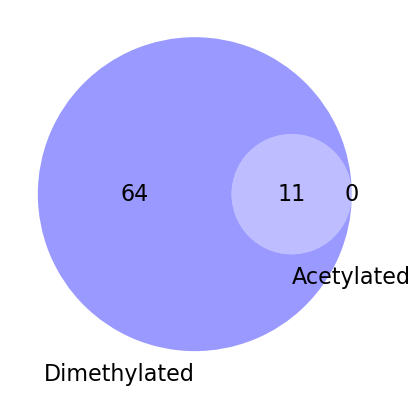

In [12]:
# Filter entries in Matched_with_targetp2_plusminus10_df where Position_Difference is 0
entries_zero = targetp2_MT_prediction_plusminus10_df[targetp2_MT_prediction_plusminus10_df['Position_Difference'] == 0]

# Filter entries in entries_zero DataFrame based on Acetylation_Status
dimethylated_entries = entries_zero[entries_zero['Modification_Status'] == 'Dimethylated']
acetylated_entries = entries_zero[entries_zero['Modification_Status'] == 'Acetylated']

# Get the sets of unique peptide sequences for dimethylated and acetylated entries
dimethylated_set = set(dimethylated_entries['Peptide Sequence'])
acetylated_set = set(acetylated_entries['Peptide Sequence'])

# Define colors for dimethylated (blue) and acetylated (grey) sets
dimethylated_color = (0, 0, 1)
acetylated_color = 'grey'

# Create a Venn diagram with custom colors using matplotlib_venn
venn = venn2([dimethylated_set, acetylated_set], set_labels=('Dimethylated', 'Acetylated'), set_colors=(dimethylated_color, acetylated_color))

# Increase font size of numbers
for text in venn.set_labels:
    text.set_fontsize(16)  # Adjust font size as needed

for text in venn.subset_labels:
    text.set_fontsize(16)  # Adjust font size as needed

# Increase font size of subset labels
for text in venn.subset_labels:
    text.set_fontsize(16)  # Adjust font size as needed

# Save the Venn diagram as a PNG file with higher resolution
plt.savefig("Figures/venn_diagram_at_position_0.png", dpi=600)
# Display the plot
plt.show()

In [13]:
# tsv files with cleavage window for ice logo generation
# Pepitdes that are modified differently can be filtered in the tsv file

output_folder = "tsv_files_for_Ice_logo_generation"
os.makedirs(output_folder, exist_ok=True)

# Select rows where the difference between 'Start_Position_in_seq' and 'Start_Position_targetp2' is 0
targetp2_MT_prediction_plusminus10_df_0 = targetp2_MT_prediction_plusminus10_df[
    (targetp2_MT_prediction_plusminus10_df['Start_Position_in_seq'] - targetp2_MT_prediction_plusminus10_df['Start_Position_targetp2']) == 0]
# Save the resulting dataframe to a TSV file
output_path_0 = os.path.join(output_folder, "targetp2_MT_prediction_plusminus10_df_0.tsv")
targetp2_MT_prediction_plusminus10_df_0.to_csv(output_path_0, sep='\t', index=False)
# Print the length (number of rows) of the dataframe
print(len(targetp2_MT_prediction_plusminus10_df_0))

# Rows where the difference between 'Start_Position_in_seq' and 'Start_Position_targetp2' is 1
targetp2_MT_prediction_plusminus10_df_1 = targetp2_MT_prediction_plusminus10_df[
    (targetp2_MT_prediction_plusminus10_df['Start_Position_in_seq'] - targetp2_MT_prediction_plusminus10_df['Start_Position_targetp2']) == 1]
output_path_1 = os.path.join(output_folder, "targetp2_MT_prediction_plusminus10_df_1.tsv")
targetp2_MT_prediction_plusminus10_df_1.to_csv(output_path_1, sep='\t', index=False)
print(len(targetp2_MT_prediction_plusminus10_df_1))

# Rows where the difference between 'Start_Position_in_seq' and 'Start_Position_targetp2' is -1
targetp2_MT_prediction_plusminus10_df_minus1 = targetp2_MT_prediction_plusminus10_df[
    (targetp2_MT_prediction_plusminus10_df['Start_Position_in_seq'] - targetp2_MT_prediction_plusminus10_df['Start_Position_targetp2']) == -1]
output_path_minus1 = os.path.join(output_folder, "targetp2_MT_prediction_plusminus10_df_minus1.tsv")
targetp2_MT_prediction_plusminus10_df_minus1.to_csv(output_path_minus1, sep='\t', index=False)
print(len(targetp2_MT_prediction_plusminus10_df_minus1))


# Filter rows where 'cleavage_window' has 'R' at the fifth position
filtered_df = targetp2_MT_prediction_plusminus10_df_0[
    targetp2_MT_prediction_plusminus10_df_0['cleavage_window'].str[4] == 'R']
# Save the resulting DataFrame to a TSV file
output_path_1 = os.path.join(output_folder, "targetp2_MT_prediction_plusminus10_df_0_R_at_P-2.tsv")
filtered_df.to_csv(output_path_1, sep='\t', index=False)
# Print the length of the filtered DataFrame
print(len(filtered_df))

# Filter rows where 'cleavage_window' has 'R' at the fourth position
filtered_df2 = targetp2_MT_prediction_plusminus10_df_0[
    targetp2_MT_prediction_plusminus10_df_0['cleavage_window'].str[3] == 'R']
output_path_2 = os.path.join(output_folder, "targetp2_MT_prediction_plusminus10_df_0_R_at_P-3.tsv")
filtered_df2.to_csv(output_path_2, sep='\t', index=False)
print(len(filtered_df2))

# Filter rows where 'cleavage_window' has 'R' at the third position
filtered_df3 = targetp2_MT_prediction_plusminus10_df_1[
    targetp2_MT_prediction_plusminus10_df_1['cleavage_window'].str[2] == 'R']
output_path_3 = os.path.join(output_folder, "targetp2_MT_prediction_plusminus10_df_1_R_at_P-4.tsv")
filtered_df3.to_csv(output_path_3, sep='\t', index=False)
print(len(filtered_df3))

# Filter rows where 'cleavage_window' has 'R' at the fourth position
filtered_df4 = targetp2_MT_prediction_plusminus10_df_1[
    targetp2_MT_prediction_plusminus10_df_1['cleavage_window'].str[3] == 'R']
output_path_4 = os.path.join(output_folder, "targetp2_MT_prediction_plusminus10_df_1_R_at_P-3.tsv")
filtered_df4.to_csv(output_path_4, sep='\t', index=False)
print(len(filtered_df4))

# Filter rows where 'cleavage_window' has 'R' at the third position
filtered_df5 = targetp2_MT_prediction_plusminus10_df_minus1[
    targetp2_MT_prediction_plusminus10_df_minus1['cleavage_window'].str[4] == 'R']
output_path_5 = os.path.join(output_folder, "targetp2_MT_prediction_plusminus10_df_minus1_R_at_P-2.tsv")
filtered_df5.to_csv(output_path_5, sep='\t', index=False)
print(len(filtered_df5))

86
26
18
32
44
10
11
17


/var/folders/bz/x13h693d4cqcf71bsncvwy_r0000gn/T/ipykernel_19215/39136178.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targetp2_MT_prediction_plusminus10_df_minus1['Peptide Sequence'] = targetp2_MT_prediction_plusminus10_df_minus1['Peptide Sequence'].str[1:]


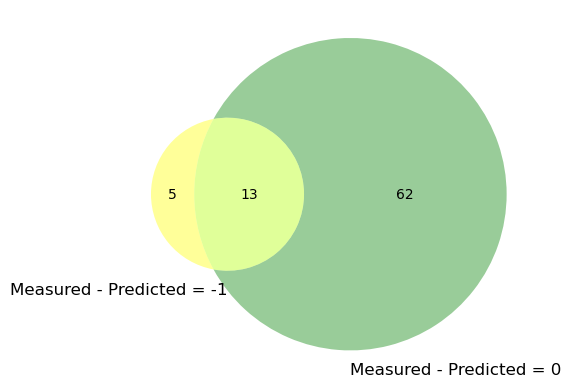

In [14]:
# Remove the first letter from "Peptide Sequence" in Matched_with_targetp2_plusminus10_df_minus1
targetp2_MT_prediction_plusminus10_df_minus1['Peptide Sequence'] = targetp2_MT_prediction_plusminus10_df_minus1['Peptide Sequence'].str[1:]

# Get the sets of unique peptide sequences for dimethylated and acetylated entries
minus1_set = set(targetp2_MT_prediction_plusminus10_df_minus1['Peptide Sequence'])
zero_set = set(targetp2_MT_prediction_plusminus10_df_0['Peptide Sequence'])

# Define colors
minus1_set_color = 'yellow'
zero_set_color = 'green'

# Create a Venn diagram with custom colors
venn2([minus1_set, zero_set], set_labels=('Measured - Predicted = -1', 'Measured - Predicted = 0'), set_colors=(minus1_set_color, zero_set_color))

# Display the plot
#plt.title('Number of Peptides in Measured - Predicted = 0 that are part of peptides in Measured - Predicted = -1')
plt.savefig("Figures/venn_diagram_0_and_-1.pdf", dpi=600)  # Save as PNG with higher resolution
plt.show()

In [16]:
# Assuming targetp2_MT_prediction is already defined and is a DataFrame
targetp2_MT_prediction_filtered = targetp2_MT_prediction

# Configure pandas to display all columns
pd.set_option('display.max_columns', None)  # None means no limit
display(targetp2_MT_prediction_filtered)

# Interactive input for column names
subset_1_cols_input = input(
    'Enter the column names for log2 ratios, separated by commas, which can be found in the data frame below (e.g., "Log2 Ratio TAILS1_combined Heavy/Light, Log2 Ratio TAILS2_combined Heavy/Light, Log2 Ratio TAILS3_combined Heavy/Light"): '
)
subset_1_cols = [col.strip() for col in subset_1_cols_input.split(',')]

# Interactive input for the number of replicates
num_replicates_input = input(
    'Enter the number of replicates in which the ratio should be present (e.g., 2): '
)
num_replicates = int(num_replicates_input)

# Interactive input for the total number of replicates (default to 3)
total_replicates_input = input(
    'Enter the total number of replicates (default is 3): '
)
total_replicates = int(total_replicates_input) if total_replicates_input else 3

# Combine conditions with logical OR operator
combined_condition = (
    (targetp2_MT_prediction_filtered[subset_1_cols].notna().sum(axis=1) >= num_replicates)
)

# Apply combined condition to filter the dataframe
targetp2_MT_prediction_filtered = targetp2_MT_prediction_filtered[combined_condition].copy()

# Further filter rows where "Prediction" is 'MT'
targetp2_MT_prediction_filtered = targetp2_MT_prediction_filtered[targetp2_MT_prediction_filtered["Prediction"] == 'MT']
print(f"{len(targetp2_MT_prediction_filtered)} Peptides matched with targetp2, present in {num_replicates} out of {total_replicates} replicates and 'MT' as Prediction")
targetp2_MT_prediction_filtered.to_csv('file_for_R_script.txt', sep='\t', index=False)

# Create a copy of the dataframe
targetp2_MT_prediction_filtered = targetp2_MT_prediction_filtered.copy()

# Interactive input for the absolute difference threshold
diff_threshold_input = input(
    'Enter the absolute difference threshold for positions (e.g., 10): '
)
diff_threshold = int(diff_threshold_input)

# Filter rows where the absolute difference between 'Start_Position_targetp2' and 'Start_Position_in_seq' is <= the specified threshold
condition = abs(targetp2_MT_prediction_filtered['Start_Position_targetp2'] - targetp2_MT_prediction_filtered['Start_Position_in_seq']) <= diff_threshold
targetp2_MT_prediction_filtered_plusminus = targetp2_MT_prediction_filtered.loc[condition].copy()
targetp2_MT_prediction_filtered_plusminus.reset_index(drop=True, inplace=True)

# Print the number of matched peptides
print(f"{len(targetp2_MT_prediction_filtered_plusminus)} Peptides matched with targetp2 +/- {diff_threshold}, present in {num_replicates} out of {total_replicates} replicates and 'MT' as Prediction")

# Create a dynamic filename based on user inputs
filename = f"targetp2_MT_prediction_{num_replicates}_out_of_{total_replicates}_replicates_plusminus{diff_threshold}.tsv"

# Save the filtered dataframe to a TSV file
targetp2_MT_prediction_filtered_plusminus.to_csv(filename, sep='\t', index=False)

print(f"Filtered data saved to {filename}")
# Log2 Ratio TAILS1_combined Heavy/Light, Log2 Ratio TAILS2_combined Heavy/Light, Log2 Ratio TAILS3_combined Heavy/Light

,Peptide Sequence,Modified Peptide,Peptide Length,Protein ID,Protein Description,Label Count,Log2 Ratio HL_new 170123_Eddy_TAILS-1_10_ST_GA9_01_1465,Light Intensity 170123_Eddy_TAILS-1_10_ST_GA9_01_1465,Heavy Intensity 170123_Eddy_TAILS-1_10_ST_GA9_01_1465,Log2 Ratio HL_new 170123_Eddy_TAILS-2_10_ST_GA10_01_1466,Light Intensity 170123_Eddy_TAILS-2_10_ST_GA10_01_1466,Heavy Intensity 170123_Eddy_TAILS-2_10_ST_GA10_01_1466,Log2 Ratio HL_new 170123_Eddy_TAILS-3_10_ST_GA11_01_1464,Light Intensity 170123_Eddy_TAILS-3_10_ST_GA11_01_1464,Heavy Intensity 170123_Eddy_TAILS-3_10_ST_GA11_01_1464,Protein Id,seq,Start_Position_in_seq,End_Position_in_seq,Amino_acid_before_Sequence,6_Amino_acids_before_Sequence,cleavage_window,# ID,Prediction,OTHER,SP,MT,Combined_CS,Start_Position_targetp2,Start_targetp2_equal_Start_observed,Modification_Status,Position_Difference
14,AADGQTQVEIKVCQGER,AADGQTQVEIKVC[57.0215]QGER,17,P38647,"Stress-70 protein, mitochondrial",2,3.165572,545449.56,4894255.5,1.675526,3475415.80,11101726.0,2.060644,2636635.20,10999318.0,P38647,MISASRAAAARLVGTAASRSPAAARPQDGWNGLSHEAFRFVSRRDY...,475,491,T,SQVFST,SQVFSTAADGQT,P38647,MT,0.019584,0.000891,0.979525,CS pos: 46-47. RDY-AS. Pr: 0.8875,47.0,False,Dimethylated,428.0
15,ADGQTQVEIKVCQGER,ADGQTQVEIKVC[57.0215]QGER,16,P38647,"Stress-70 protein, mitochondrial",2,2.007944,5225335.00,21016752.0,2.195916,8991804.00,41198704.0,0.917619,1136521.20,2146882.5,P38647,MISASRAAAARLVGTAASRSPAAARPQDGWNGLSHEAFRFVSRRDY...,476,491,A,QVFSTA,QVFSTAADGQTQ,P38647,MT,0.019584,0.000891,0.979525,CS pos: 46-47. RDY-AS. Pr: 0.8875,47.0,False,Dimethylated,429.0
16,AFTADGERLVGMPAKRQAVTNPNNTFYATKR,AFTADGERLVGMPAKRQAVTNPNNTFYATKR,31,P38647,"Stress-70 protein, mitochondrial",2,0.379429,305315.44,397162.6,NaN,NaN,NaN,NaN,NaN,NaN,P38647,MISASRAAAARLVGTAASRSPAAARPQDGWNGLSHEAFRFVSRRDY...,92,122,V,TTPSVV,TTPSVVAFTADG,P38647,MT,0.019584,0.000891,0.979525,CS pos: 46-47. RDY-AS. Pr: 0.8875,47.0,False,Dimethylated,45.0
17,AGQISGLNVLR,AGQISGLNVLR,11,P38647,"Stress-70 protein, mitochondrial",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,615756.56,NaN,P38647,MISASRAAAARLVGTAASRSPAAARPQDGWNGLSHEAFRFVSRRDY...,208,218,D,RQATKD,RQATKDAGQISG,P38647,MT,0.019584,0.000891,0.979525,CS pos: 46-47. RDY-AS. Pr: 0.8875,47.0,False,Dimethylated,161.0
18,AQFEGIVTDLIKR,AQFEGIVTDLIKR,13,P38647,"Stress-70 protein, mitochondrial",2,NaN,NaN,NaN,NaN,NaN,NaN,-0.074802,2777790.20,2637435.0,P38647,MISASRAAAARLVGTAASRSPAAARPQDGWNGLSHEAFRFVSRRDY...,349,361,R,NMKLTR,NMKLTRAQFEGI,P38647,MT,0.019584,0.000891,0.979525,CS pos: 46-47. RDY-AS. Pr: 0.8875,47.0,False,Dimethylated,302.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2123,VSDSSDSMDTGAGSIR,VSDSSDSMDTGAGSIR,16,O35143,"ATPase inhibitor, mitochondrial",1,NaN,NaN,NaN,NaN,NaN,NaN,1.840590,1300183.80,4656691.0,O35143,MAGSALAVRARFGVWGMKVLQTRGFVSDSSDSMDTGAGSIREAGGA...,26,41,F,LQTRGF,LQTRGFVSDSSD,O35143,MT,0.129235,0.000084,0.870681,CS pos: 25-26. RGF-VS. Pr: 0.8382,26.0,True,Dimethylated,0.0
2124,VSEGSAAMAAGESMAQR,VSEGSAAMAAGESMAQR,17,Q9D8S4,"Oligoribonuclease, mitochondrial",1,NaN,NaN,NaN,2.915581,758195.56,5720823.0,NaN,NaN,NaN,Q9D8S4,MLGVSLGARLLRGVGGRRGQFGARGVSEGSAAMAAGESMAQRMVWV...,26,42,G,QFGARG,QFGARGVSEGSA,Q9D8S4,MT,0.017084,0.000061,0.982855,CS pos: 25-26. ARG-VS. Pr: 0.3175,26.0,True,Dimethylated,0.0
2126,VTGAPVPAVSEPQDGDDFQSR,VTGAPVPAVSEPQDGDDFQSR,21,Q924T2,Small ribosomal subunit protein uS2m,1,1.498807,3416265.50,9654669.0,1.689428,5568237.94,17959170.0,1.296615,4469789.50,10980120.0,Q924T2,MAPAPAVLTRLLCAGVRRWPGFLQKAIPGPAEQNGRKVTGAPVPAV...,38,58,K,EQNGRK,EQNGRKVTGAPV,Q924T2,MT,0.252365,0.019707,0.727928,CS pos: 23-24. GFL-QK. Pr: 0.1103,24.0,False,Dimethylated,14.0
2129,YHKKVVDHYENPR,YHKKVVDHYENPR,13,Q9D7P6,Iron-sulfur cluster assembly enzyme ISCU,3,0.070739,5559100.00,5838469.0,NaN,NaN,NaN,0.128634,5684855.00,6215012.5,Q9D7P6,MAAATGAGRLRRAASALLLRSPRLPARELSAPARLYHKKVVDHYEN...,36,48,L,SAPARL,SAPARLYHKKVV,Q9D7P6,MT,0.013458,

Enter the column names for log2 ratios, separated by commas, which can be found in the data frame below (e.g., "Log2 Ratio TAILS1_combined Heavy/Light, Log2 Ratio TAILS2_combined Heavy/Light, Log2 Ratio TAILS3_combined Heavy/Light"): Log2 Ratio HL_new 170123_Eddy_TAILS-1_10_ST_GA9_01_1465,Log2 Ratio HL_new 170123_Eddy_TAILS-2_10_ST_GA10_01_1466,Log2 Ratio HL_new 170123_Eddy_TAILS-3_10_ST_GA11_01_1464
Enter the number of replicates in which the ratio should be present (e.g., 2): 2
Enter the total number of replicates (default is 3): 3
664 Peptides matched with targetp2, present in 2 out of 3 replicates and 'MT' as Prediction
Enter the absolute difference threshold for positions (e.g., 10): 10
157 Peptides matched with targetp2 +/- 10, present in 2 out of 3 replicates and 'MT' as Prediction
Filtered data saved to targetp2_MT_prediction_2_out_of_3_replicates_plusminus10.tsv


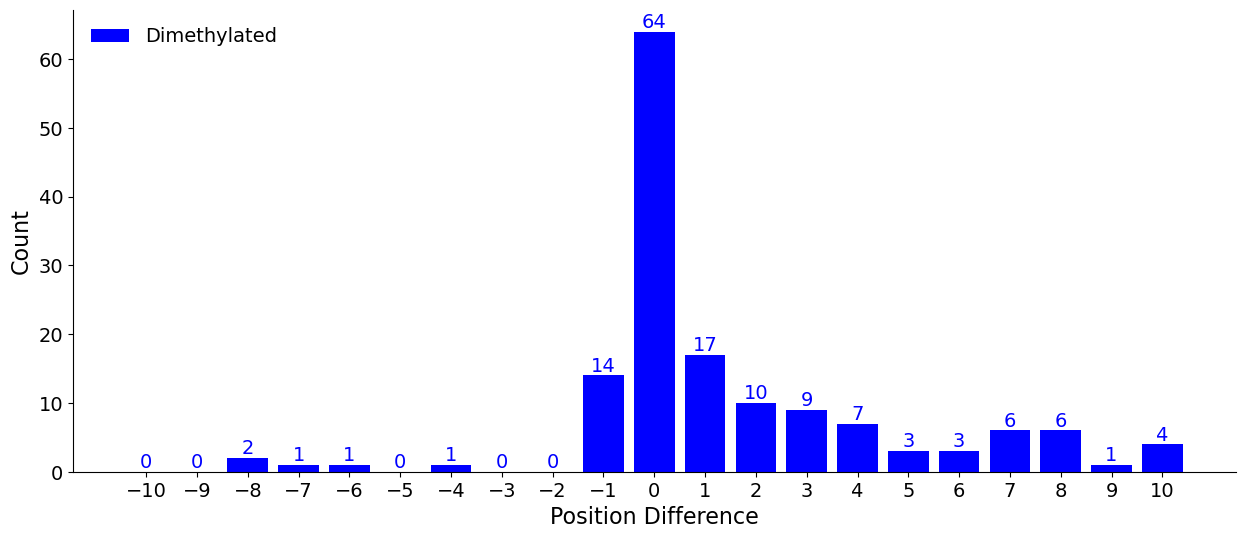

In [17]:
# Define the filename based on user inputs from the previous cell
filename = f"targetp2_MT_prediction_{num_replicates}_out_of_{total_replicates}_replicates_plusminus{diff_threshold}.tsv"

# Load the filtered DataFrame from the file
targetp2_MT_prediction_filtered_plusminus = pd.read_csv(filename, sep='\t')

# Display the DataFrame
pd.set_option('display.max_columns', None)  # None means no limit

# Create a Series with the complete range of values from -10 to 10 and fill missing values with zeros
full_range = pd.Series(0, index=range(-10, 11))

# Filter entries with "Dimethylated" status
entries_dimethylated = targetp2_MT_prediction_filtered_plusminus['Modification_Status'] == 'Dimethylated'

# Count occurrences of each unique value for entries with "Dimethylated" status
difference_counts_dimethylated = (
    targetp2_MT_prediction_filtered_plusminus[entries_dimethylated]['Position_Difference']
    .value_counts()
    .sort_index())

# Reindex to the full range and fill missing values with 0
difference_counts_dimethylated = difference_counts_dimethylated.reindex(full_range.index, fill_value=0)

# Filter out bars with a count of 0
# difference_counts_dimethylated = difference_counts_dimethylated[difference_counts_dimethylated != 0]

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(15, 6))

# Plot bars for entries with "Dimethylated" status in blue
bars1 = ax.bar(difference_counts_dimethylated.index, difference_counts_dimethylated.values, color='blue', label='Dimethylated')

# Filter entries with "Acetylated" status
entries_acetylated = targetp2_MT_prediction_filtered_plusminus['Modification_Status'] == 'Acetylated'

# Count occurrences of each unique value for entries with "Acetylated" status
difference_counts_acetylated = (
    targetp2_MT_prediction_filtered_plusminus[entries_acetylated]['Position_Difference']
    .value_counts()
    .sort_index())

# Reindex to the full range and fill missing values with 0
difference_counts_acetylated = difference_counts_acetylated.reindex(full_range.index, fill_value=0)

# Filter out bars with a count of 0
difference_counts_acetylated = difference_counts_acetylated[difference_counts_acetylated != 0]


# Plot bars for entries with "Acetylated" status in red
#bars2 = ax.bar(difference_counts_acetylated.index, difference_counts_acetylated.values, color='orange', label='Acetylated')

# Add labels with counts on top of each bar
for bars, counts, color in zip([bars1], [difference_counts_dimethylated], ['blue']):
    for bar, count in zip(bars, counts):
        ax.text(
            bar.get_x() + bar.get_width() / 2, 
            count, 
            str(count), 
            ha='center', 
            va='bottom', 
            color=color,
            fontsize=14)

ax.set_xlabel('Position Difference', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
#ax.set_title('Start Position of measured Peptides by Acetylation Status (Measured - Predicted)')

# Customize y-axis tick labels
ax.tick_params(axis='y', labelsize=14) 
# Customize x-axis tick labels
ax.tick_params(axis='x', labelsize=14) 

# Remove left spine
ax.spines['right'].set_visible(False)
# Remove top spine
ax.spines['top'].set_visible(False)

# Set integer ticks on the x-axis
plt.xticks([int(x) for x in difference_counts_dimethylated.index])
# Add legend
plt.legend(fontsize=14, loc='upper left', frameon=False)
# Save the plot as a PNG file with higher resolution
plt.savefig("Figures/histograms_measured-predicted_filtered.pdf", dpi=600)

plt.show()

# Save the DataFrame to a TSV file

In [20]:
# Assuming the previous cell has defined these variables
filename = f"targetp2_MT_prediction_{num_replicates}_out_of_{total_replicates}_replicates_plusminus{diff_threshold}.tsv"

# Load the filtered DataFrame from the file
targetp2_MT_prediction_filtered_plusminus = pd.read_csv(filename, sep='\t')

# Define the output folder (make sure to adjust this path as needed)
output_folder = "output_folder_path"  # Replace with your actual output folder path
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Select rows where the difference between 'Start_Position_in_seq' and 'Start_Position_targetp2' is 0
targetp2_0 = targetp2_MT_prediction_filtered_plusminus[
    (targetp2_MT_prediction_filtered_plusminus['Start_Position_in_seq'] - targetp2_MT_prediction_filtered_plusminus['Start_Position_targetp2']) == 0]
output_path_0 = os.path.join(output_folder, f"{filename.split('.')[0]}_0.tsv")
targetp2_0.to_csv(output_path_0, sep='\t', index=False)
print(len(targetp2_0))

# Rows where the difference between 'Start_Position_in_seq' and 'Start_Position_targetp2' is 1
targetp2_1 = targetp2_MT_prediction_filtered_plusminus[
    (targetp2_MT_prediction_filtered_plusminus['Start_Position_in_seq'] - targetp2_MT_prediction_filtered_plusminus['Start_Position_targetp2']) == 1]
output_path_1 = os.path.join(output_folder, f"{filename.split('.')[0]}_1.tsv")
targetp2_1.to_csv(output_path_1, sep='\t', index=False)
print(len(targetp2_1))

# Rows where the difference between 'Start_Position_in_seq' and 'Start_Position_targetp2' is -1
targetp2_minus1 = targetp2_MT_prediction_filtered_plusminus[
    (targetp2_MT_prediction_filtered_plusminus['Start_Position_in_seq'] - targetp2_MT_prediction_filtered_plusminus['Start_Position_targetp2']) == -1]
output_path_minus1 = os.path.join(output_folder, f"{filename.split('.')[0]}_minus1.tsv")
targetp2_minus1.to_csv(output_path_minus1, sep='\t', index=False)
print(len(targetp2_minus1))

# Filter rows where 'cleavage_window' has 'R' at the fifth position in targetp2_0
filtered_df = targetp2_0[
    targetp2_0['cleavage_window'].str[4] == 'R']
output_path_filtered = os.path.join(output_folder, f"{filename.split('.')[0]}_0_R_at_P-2.tsv")
filtered_df.to_csv(output_path_filtered, sep='\t', index=False)
print(len(filtered_df))

# Filter rows where 'cleavage_window' has 'R' at the fourth position in targetp2_0
filtered_df2 = targetp2_0[
    targetp2_0['cleavage_window'].str[3] == 'R']
output_path_filtered2 = os.path.join(output_folder, f"{filename.split('.')[0]}_0_R_at_P-3.tsv")
filtered_df2.to_csv(output_path_filtered2, sep='\t', index=False)
print(len(filtered_df2))

# Filter rows where 'cleavage_window' has 'R' at the third position in targetp2_1
filtered_df3 = targetp2_1[
    targetp2_1['cleavage_window'].str[2] == 'R']
output_path_filtered3 = os.path.join(output_folder, f"{filename.split('.')[0]}_1_R_at_P-4.tsv")
filtered_df3.to_csv(output_path_filtered3, sep='\t', index=False)
print(len(filtered_df3))

# Filter rows where 'cleavage_window' has 'R' at the fourth position in targetp2_1
filtered_df4 = targetp2_1[
    targetp2_1['cleavage_window'].str[3] == 'R']
output_path_filtered4 = os.path.join(output_folder, f"{filename.split('.')[0]}_1_R_at_P-3.tsv")
filtered_df4.to_csv(output_path_filtered4, sep='\t', index=False)
print(len(filtered_df4))

# Filter rows where 'cleavage_window' has 'R' at the fifth position in targetp2_minus1
filtered_df5 = targetp2_minus1[
    targetp2_minus1['cleavage_window'].str[4] == 'R']
output_path_filtered5 = os.path.join(output_folder, f"{filename.split('.')[0]}_minus1_R_at_P-2.tsv")
filtered_df5.to_csv(output_path_filtered5, sep='\t', index=False)
print(len(filtered_df5))


71
17
14
26
34
5
9
14


Number of rows in df_intensity: 2131
Number of rows in df_intensity_MT: 1052


,Peptide Sequence,Modified Peptide,Peptide Length,Protein ID,Protein Description,Label Count,Log2 Ratio HL_new 170123_Eddy_TAILS-1_10_ST_GA9_01_1465,Light Intensity 170123_Eddy_TAILS-1_10_ST_GA9_01_1465,Heavy Intensity 170123_Eddy_TAILS-1_10_ST_GA9_01_1465,Log2 Ratio HL_new 170123_Eddy_TAILS-2_10_ST_GA10_01_1466,Light Intensity 170123_Eddy_TAILS-2_10_ST_GA10_01_1466,Heavy Intensity 170123_Eddy_TAILS-2_10_ST_GA10_01_1466,Log2 Ratio HL_new 170123_Eddy_TAILS-3_10_ST_GA11_01_1464,Light Intensity 170123_Eddy_TAILS-3_10_ST_GA11_01_1464,Heavy Intensity 170123_Eddy_TAILS-3_10_ST_GA11_01_1464,log10_Light Intensity 170123_Eddy_TAILS-2_10_ST_GA10_01_1466,log10_Light Intensity 170123_Eddy_TAILS-3_10_ST_GA11_01_1464,log10_Light Intensity 170123_Eddy_TAILS-1_10_ST_GA9_01_1465
0,AAAAAASTSVKPIFSR,AAAAAASTSVKPIFSR,16,Q9CQZ5,NADH dehydrogenase [ubiquinone] 1 alpha subcom...,2,1.919845,4343162.0,16433756.0,4.028143,1119475.6,18264440.0,1.783930,7287830.0,25096590.0,6.049015,6.862598,6.637806
1,AAAAASTSVKPIFSR,AAAAASTSVKPIFSR,15,Q9CQZ5,NADH dehydrogenase [ubiquinone] 1 alpha subcom...,2,0.099293,20461740.0,21919606.0,0.019033,24547612.0,24873604.0,0.241045,25216658.0,29802264.0,7.390009,7.401688,7.310943
2,AAAASTSVKPIFSR,AAAASTSVKPIFSR,14,Q9CQZ5,NADH dehydrogenase [ubiquinone] 1 alpha subcom...,2,2.591648,7184265.5,43305812.0,2.744094,6323783.0,42367380.0,2.178277,9976693.0,45155770.0,6.800977,6.998987,6.856382
3,AAAKVALTKR,n[42.0106]AAAKVALTKR,10,Q8C140,EF-hand domain-containing protein,2,-0.165233,18300684.0,16320261.0,1.199196,8834740.0,20285590.0,-0.959285,43269224.0,22253876.0,6.946194,7.636179,7.262467
4,AAASTSVKPIFSR,AAASTSVKPIFSR,13,Q9CQZ5,NADH dehydrogenase [ubiquinone] 1 alpha subcom...,2,2.913600,5842331.0,44021747.5,4.874093,1813116.6,53170892.0,3.075579,6148793.0,51835976.0,6.258426,6.788790,6.766586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2126,YTDQSGEEEEDYESEEQLQHR,YTDQSGEEEEDYESEEQLQHR,21,Q8K1Z0,"Ubiquinone biosynthesis protein COQ9, mitochon...",1,-1.379312,2374377.8,912716.0,-2.046015,2688463.2,651017.0,-1.741815,2971040.5,888321.0,6.429504,6.472909,6.375550
2127,YTGTLDCWR,YTGTLDC[57.0215]WR,9,P48962,ADP/ATP translocase 1,1,0.741107,42599972.0,71204050.0,0.838314,35560828.0,63581332.0,NaN,NaN,NaN,7.550972,NaN,7.629409
2128,YTQQMEDLKR,YTQQMEDLKR,10,Q2TAW4,Myosin-6,2,NaN,NaN,NaN,NaN,NaN,NaN,-1.143116,23622208.0,10695678.0,NaN,7.373320,NaN
2129,YVGENAEFER,YVGENAEFER,10,Q9D0K2,Succinyl-CoA:3-ketoacid coenzyme A transferase...,1,0.490361,10254834.0,14405958.0,0.816584,9276354.0,16337797.0,0.793845,10699352.0,18549344.0,6.967377,7.029357,7.010929


Enter the intensity column names, separated by commas (e.g., "Light Intensity TAILS1_combined, Heavy Intensity TAILS1_combined"): Light Intensity 170123_Eddy_TAILS-1_10_ST_GA9_01_1465,Heavy Intensity 170123_Eddy_TAILS-1_10_ST_GA9_01_1465


/var/folders/bz/x13h693d4cqcf71bsncvwy_r0000gn/T/ipykernel_19215/1395011920.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_intensity_MT[log10_columns] = df_intensity_MT[intensity_columns].apply(lambda x: np.log10(x))
/var/folders/bz/x13h693d4cqcf71bsncvwy_r0000gn/T/ipykernel_19215/1395011920.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_intensity_MT[log10_columns] = df_intensity_MT[intensity_columns].apply(lambda x: np.log10(x))


Enter the y-axis limit for the histograms (e.g., 90): 90
Enter the x-axis limits for the histograms in the format "min,max" (e.g., "4,10"): 4,10
Enter the filename for the saved plot (e.g., "histograms_log10.pdf"): 


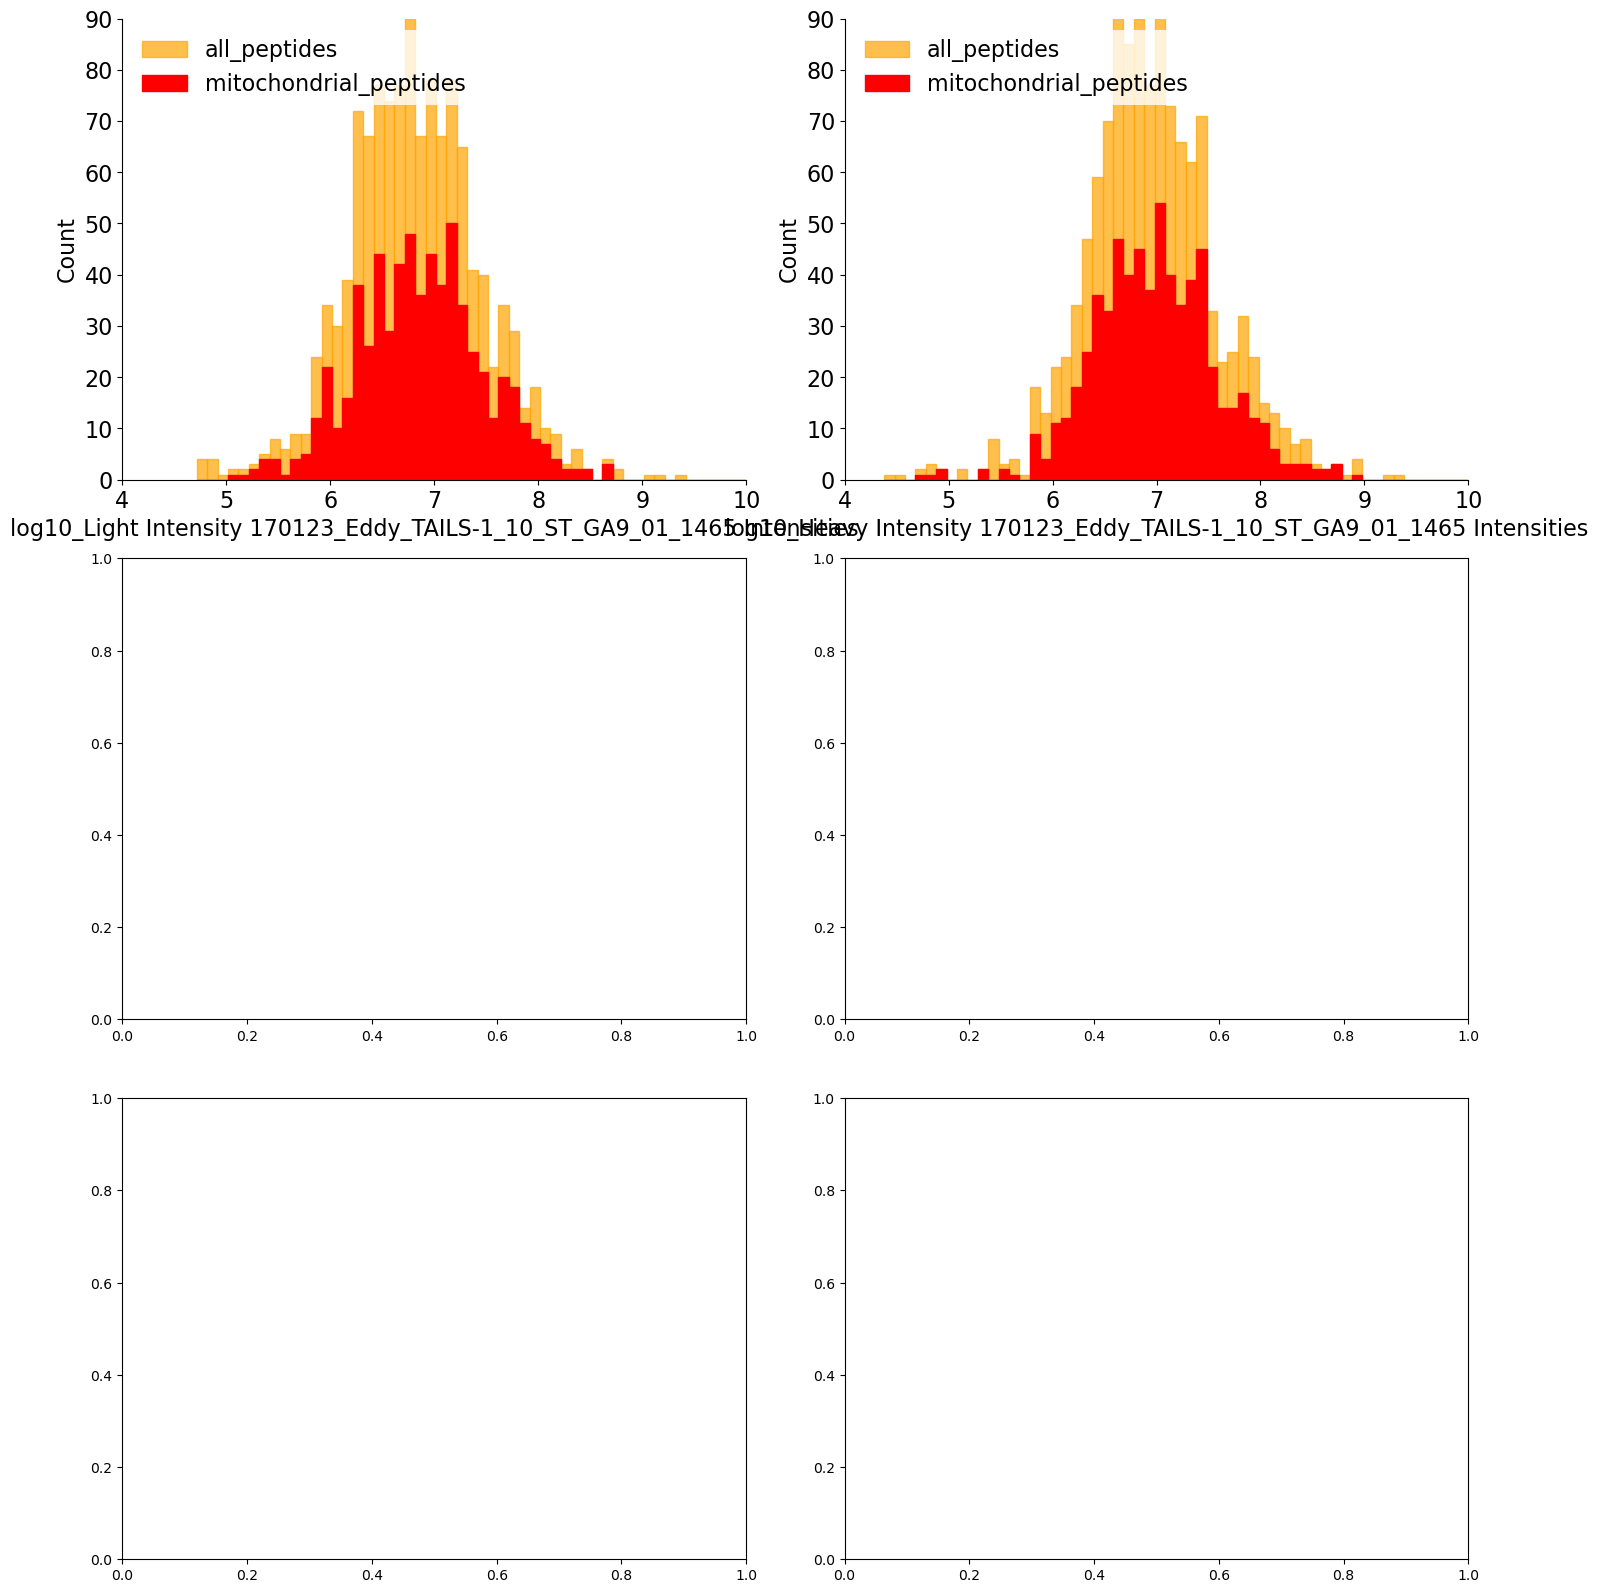

In [21]:
# Assuming combined_df_without_pyro and targetp2_MT_prediction are already defined as DataFrames
df_intensity = combined_df_without_pyro
df_intensity_MT = targetp2_MT_prediction

# Print the lengths of the dataframes
print(f"Number of rows in df_intensity: {len(df_intensity)}")
print(f"Number of rows in df_intensity_MT: {len(df_intensity_MT)}")

# Display df_intensity
display(df_intensity)

# Interactive input for intensity column names
intensity_columns_input = input(
    'Enter the intensity column names, separated by commas (e.g., "Light Intensity TAILS1_combined, Heavy Intensity TAILS1_combined"): '
)
intensity_columns = [col.strip() for col in intensity_columns_input.split(',')]

# Create new columns with log10-transformed values
log10_columns = [f'log10_{col}' for col in intensity_columns]
df_intensity[log10_columns] = df_intensity[intensity_columns].apply(lambda x: np.log10(x))
df_intensity_MT[log10_columns] = df_intensity_MT[intensity_columns].apply(lambda x: np.log10(x))

# Interactive input for y-axis limit
y_limit_input = input('Enter the y-axis limit for the histograms (e.g., 90): ')
y_limit = int(y_limit_input) if y_limit_input else 90

# Interactive input for x-axis limit
x_limit_input = input('Enter the x-axis limits for the histograms in the format "min,max" (e.g., "4,10"): ')
x_limit = [int(x) for x in x_limit_input.split(',')] if x_limit_input else [4, 10]

# Set up subplots for log10-transformed values
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 18))
fig.tight_layout(pad=4.0)

# Plot histograms for log10-transformed values
for i, log10_column in enumerate(log10_columns):
    # Extract the current log10-transformed column
    log10_values = df_intensity[log10_column]
    log10_values_MT = df_intensity_MT[log10_column]
    
    # Set up the histogram
    max_x_value = np.ceil(log10_values.max()) + 1
    bin_edges = np.arange(log10_values.min(), max_x_value + 0.1, 0.1)
    bin_edges[-1] = max_x_value

    # Plot the histogram on the corresponding subplot
    row = i // 2
    col = i % 2
    axes[row, col].hist(log10_values, bins=bin_edges, edgecolor='orange', alpha=0.7, color='orange', label='all_peptides')
    axes[row, col].hist(log10_values_MT, bins=bin_edges, edgecolor='red', color='red', label='mitochondrial_peptides')
    
    # Set labels and title for each subplot
    axes[row, col].set_xlabel(f'{log10_column} Intensities', fontsize=16)
    axes[row, col].set_ylabel('Count', fontsize=16)
    
    # Customize y-axis tick labels
    axes[row, col].tick_params(axis='y', labelsize=16) 
    # Customize x-axis tick labels
    axes[row, col].tick_params(axis='x', labelsize=16)  
    
    # Set y-axis limit
    axes[row, col].set_ylim(0, y_limit)
    # Set x-axis limit
    axes[row, col].set_xlim(x_limit)
    
    # Add legend
    legend = axes[row, col].legend(fontsize=16, loc='upper left')
    legend.get_frame().set_linewidth(0)  # Remove legend frame
    
    # Remove left spine
    axes[row, col].spines['right'].set_visible(False)
    # Remove top spine
    axes[row, col].spines['top'].set_visible(False)

# Adjust layout
plt.subplots_adjust(top=0.9)

# Save the figure as a PDF
fig_filename = input('Enter the filename for the saved plot (e.g., "histograms_log10.pdf"): ')
plt.savefig(f"Figures/{fig_filename}")

# Show the plots
plt.show()

#Light Intensity TAILS1_combined,Heavy Intensity TAILS1_combined,Light Intensity TAILS2_combined,Heavy Intensity TAILS2_combined ,Light Intensity TAILS3_combined,Heavy Intensity TAILS3_combined

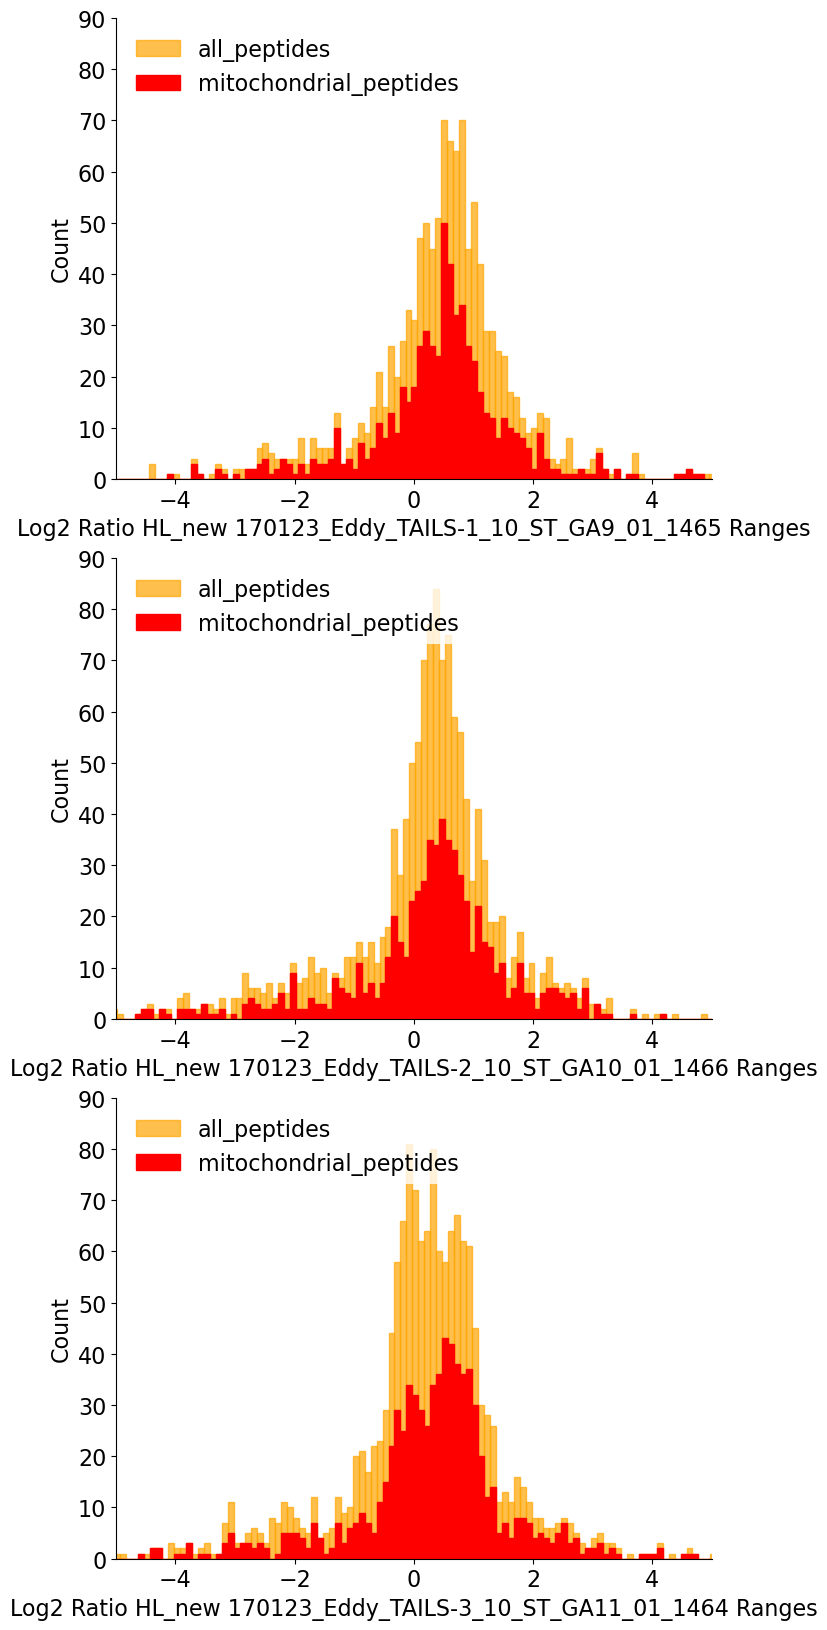

In [22]:
# Read the dataframes
df_intensity_all = combined_df_without_pyro
df_intensity_targetp2 = targetp2_MT_prediction

# Specify the intensity columns
#log2_columns = ['Log2 Ratio TAILS1_combined Heavy/Light', 'Log2 Ratio TAILS2_combined Heavy/Light', 'Log2 Ratio TAILS3_combined Heavy/Light']
log2_columns = subset_1_cols 
# Set up subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7.5, 18))
fig.tight_layout(pad=4.0)

for i, log2_column in enumerate(log2_columns):
    # Extract the current intensity columns
    log2_values_targetp2 = df_intensity_targetp2[log2_column]
    log2_values_all = df_intensity_all[log2_column]

    # Set up the histogram
    max_x_value = 7.5
    bin_edges = np.arange(min(log2_values_targetp2.min(), log2_values_all.min()), max_x_value + 0.1, 0.1)
    bin_edges[-1] = max_x_value  # Set the last bin edge to the maximum x value

    # Plot the histogram on the corresponding subplot for all
    axes[i].hist(log2_values_all, bins=bin_edges, edgecolor='orange', alpha=0.7, color='orange', label='all_peptides')
    axes[i].hist(log2_values_targetp2, bins=bin_edges, edgecolor='red', color='red', label='mitochondrial_peptides')

    # Set labels and title for each subplot
    axes[i].set_xlabel(f'{log2_column} Ranges', fontsize =16)
    axes[i].set_ylabel('Count', fontsize =16)
    #axes[i].set_title(f'Histogram of {log2_column}')
    
     # Customize y-axis tick labels
    axes[i].tick_params(axis='y', labelsize=16) 
    # Customize x-axis tick labels
    axes[i].tick_params(axis='x', labelsize=16) 
    
    # Set y-axis limit for all subplots
    axes[i].set_ylim(0, 90)
    axes[i].set_xlim(-5, 5)
    #axes[i].legend(fontsize = 16,loc='upper left')
    legend = axes[i].legend(fontsize=16,loc='upper left')
    legend.get_frame().set_linewidth(0)  # Remove legend frame
    
    # Remove left spine
    axes[i].spines['right'].set_visible(False)
    # Remove top spine
    axes[i].spines['top'].set_visible(False)
    
# Adjust layout
plt.subplots_adjust(top=0.9)
plt.savefig("Figures/histograms_log2_combined.pdf")
plt.show()



In [23]:
# Calculate median values for each replicate and normalization category based on all peptides
median_values_H_over_L = [statistics.median(combined_df_without_pyro[f'{subset_1_col}'].value_counts().index.to_list()) for subset_1_col in subset_1_cols]
print(median_values_H_over_L)

# Create a copy of the DataFrame
targetp2_MT_prediction_filtered_copy = targetp2_MT_prediction_filtered.copy()

# Normalize Log2 Ratio A9/WT
for subset_1_col, median_value in zip(subset_1_cols, median_values_H_over_L):
    targetp2_MT_prediction_filtered_copy[f'Log2 Ratio noramlized {subset_1_col}'] = (
        targetp2_MT_prediction_filtered_copy[f'{subset_1_col}'] - median_value)

# Reset index and display the DataFrame
targetp2_MT_prediction_filtered_copy = targetp2_MT_prediction_filtered_copy.reset_index(drop=True)

# Define column subsets
subset_1_cols = [f'Log2 Ratio noramlized {subset_1_col}' for subset_1_col in subset_1_cols]

[0.5559067767265622, 0.3471329533588598, 0.2604884501420207]


In [24]:
# Extracting column names for light and heavy intensities
light_columns = [col for col in targetp2_MT_prediction_filtered_copy.columns if 'Light Intensity' in col]
heavy_columns = [col for col in targetp2_MT_prediction_filtered_copy.columns if 'Heavy Intensity' in col]

# Calculate mean for light intensity columns and add a new column 'Light Intensity mean'
targetp2_MT_prediction_filtered_copy['Light Intensity mean'] = targetp2_MT_prediction_filtered_copy[light_columns].mean(axis=1)

# Calculate mean for heavy intensity columns and add a new column 'Heavy Intensity mean'
targetp2_MT_prediction_filtered_copy['Heavy Intensity mean'] = targetp2_MT_prediction_filtered_copy[heavy_columns].mean(axis=1)

,Peptide Sequence,Modified Peptide,Peptide Length,Protein ID,Protein Description,Label Count,Log2 Ratio HL_new 170123_Eddy_TAILS-1_10_ST_GA9_01_1465,Light Intensity 170123_Eddy_TAILS-1_10_ST_GA9_01_1465,Heavy Intensity 170123_Eddy_TAILS-1_10_ST_GA9_01_1465,Log2 Ratio HL_new 170123_Eddy_TAILS-2_10_ST_GA10_01_1466,Light Intensity 170123_Eddy_TAILS-2_10_ST_GA10_01_1466,Heavy Intensity 170123_Eddy_TAILS-2_10_ST_GA10_01_1466,Log2 Ratio HL_new 170123_Eddy_TAILS-3_10_ST_GA11_01_1464,Light Intensity 170123_Eddy_TAILS-3_10_ST_GA11_01_1464,Heavy Intensity 170123_Eddy_TAILS-3_10_ST_GA11_01_1464,Protein Id,seq,Start_Position_in_seq,End_Position_in_seq,Amino_acid_before_Sequence,6_Amino_acids_before_Sequence,cleavage_window,# ID,Prediction,OTHER,SP,MT,Combined_CS,Start_Position_targetp2,Start_targetp2_equal_Start_observed,Modification_Status,Position_Difference,log10_Light Intensity 170123_Eddy_TAILS-2_10_ST_GA10_01_1466,log10_Light Intensity 170123_Eddy_TAILS-3_10_ST_GA11_01_1464,log10_Light Intensity 170123_Eddy_TAILS-1_10_ST_GA9_01_1465,log10_Heavy Intensity 170123_Eddy_TAILS-1_10_ST_GA9_01_1465
14,AADGQTQVEIKVCQGER,AADGQTQVEIKVC[57.0215]QGER,17,P38647,"Stress-70 protein, mitochondrial",2,3.165572,545449.56,4894255.5,1.675526,3475415.80,11101726.0,2.060644,2636635.20,10999318.0,P38647,MISASRAAAARLVGTAASRSPAAARPQDGWNGLSHEAFRFVSRRDY...,475,491,T,SQVFST,SQVFSTAADGQT,P38647,MT,0.019584,0.000891,0.979525,CS pos: 46-47. RDY-AS. Pr: 0.8875,47.0,False,Dimethylated,428.0,6.541007,6.421050,5.736755,6.689687
15,ADGQTQVEIKVCQGER,ADGQTQVEIKVC[57.0215]QGER,16,P38647,"Stress-70 protein, mitochondrial",2,2.007944,5225335.00,21016752.0,2.195916,8991804.00,41198704.0,0.917619,1136521.20,2146882.5,P38647,MISASRAAAARLVGTAASRSPAAARPQDGWNGLSHEAFRFVSRRDY...,476,491,A,QVFSTA,QVFSTAADGQTQ,P38647,MT,0.019584,0.000891,0.979525,CS pos: 46-47. RDY-AS. Pr: 0.8875,47.0,False,Dimethylated,429.0,6.953847,6.055578,6.718114,7.322566
16,AFTADGERLVGMPAKRQAVTNPNNTFYATKR,AFTADGERLVGMPAKRQAVTNPNNTFYATKR,31,P38647,"Stress-70 protein, mitochondrial",2,0.379429,305315.44,397162.6,NaN,NaN,NaN,NaN,NaN,NaN,P38647,MISASRAAAARLVGTAASRSPAAARPQDGWNGLSHEAFRFVSRRDY...,92,122,V,TTPSVV,TTPSVVAFTADG,P38647,MT,0.019584,0.000891,0.979525,CS pos: 46-47. RDY-AS. Pr: 0.8875,47.0,False,Dimethylated,45.0,NaN,NaN,5.484749,5.598968
17,AGQISGLNVLR,AGQISGLNVLR,11,P38647,"Stress-70 protein, mitochondrial",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,615756.56,NaN,P38647,MISASRAAAARLVGTAASRSPAAARPQDGWNGLSHEAFRFVSRRDY...,208,218,D,RQATKD,RQATKDAGQISG,P38647,MT,0.019584,0.000891,0.979525,CS pos: 46-47. RDY-AS. Pr: 0.8875,47.0,False,Dimethylated,161.0,NaN,5.789409,NaN,NaN
18,AQFEGIVTDLIKR,AQFEGIVTDLIKR,13,P38647,"Stress-70 protein, mitochondrial",2,NaN,NaN,NaN,NaN,NaN,NaN,-0.074802,2777790.20,2637435.0,P38647,MISASRAAAARLVGTAASRSPAAARPQDGWNGLSHEAFRFVSRRDY...,349,361,R,NMKLTR,NMKLTRAQFEGI,P38647,MT,0.019584,0.000891,0.979525,CS pos: 46-47. RDY-AS. Pr: 0.8875,47.0,False,Dimethylated,302.0,NaN,6.443699,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2123,VSDSSDSMDTGAGSIR,VSDSSDSMDTGAGSIR,16,O35143,"ATPase inhibitor, mitochondrial",1,NaN,NaN,NaN,NaN,NaN,NaN,1.840590,1300183.80,4656691.0,O35143,MAGSALAVRARFGVWGMKVLQTRGFVSDSSDSMDTGAGSIREAGGA...,26,41,F,LQTRGF,LQTRGFVSDSSD,O35143,MT,0.129235,0.000084,0.870681,CS pos: 25-26. RGF-VS. Pr: 0.8382,26.0,True,Dimethylated,0.0,NaN,6.114005,NaN,NaN
2124,VSEGSAAMAAGESMAQR,VSEGSAAMAAGESMAQR,17,Q9D8S4,"Oligoribonuclease, mitochondrial",1,NaN,NaN,NaN,2.915581,758195.56,5720823.0,NaN,NaN,NaN,Q9D8S4,MLGVSLGARLLRGVGGRRGQFGARGVSEGSAAMAAGESMAQRMVWV...,26,42,G,QFGARG,QFGARGVSEGSA,Q9D8S4,MT,0.017084,0.000061,0.982855,CS pos: 25-26. ARG-VS. Pr: 0.3175,26.0,True,Dimethylated,0.0,5.879781,NaN,NaN,NaN
2126,VTGAPVPAVSEPQDGDDFQSR,VTGAPVPAVSEPQDGDDFQSR,21,Q924T2,Small ribosomal subunit protein uS2m,1,1.498807,3416265.50,9654669.0,1.689428,5568237.94,17959170.0,1.296615,4469789.50,10980120.0,Q924T2,

Enter the light intensity column names, separated by commas: Light Intensity 170123_Eddy_TAILS-1_10_ST_GA9_01_1465,Light Intensity 170123_Eddy_TAILS-2_10_ST_GA10_01_1466,Light Intensity 170123_Eddy_TAILS-3_10_ST_GA11_01_1464
Enter the heavy intensity column names, separated by commas: Heavy Intensity 170123_Eddy_TAILS-3_10_ST_GA11_01_1464,Heavy Intensity 170123_Eddy_TAILS-2_10_ST_GA10_01_1466,Heavy Intensity 170123_Eddy_TAILS-1_10_ST_GA9_01_1465


/var/folders/bz/x13h693d4cqcf71bsncvwy_r0000gn/T/ipykernel_19215/1449766173.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Peptides_only_in_light_channel['Log2_Avg_Light_Intensity'] = np.log2(


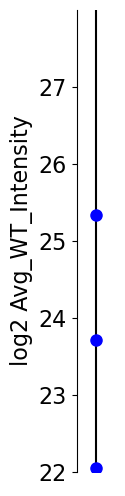

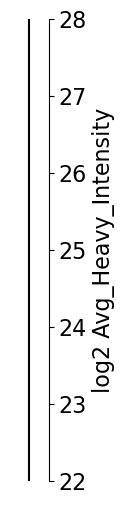

In [25]:
display(targetp2_MT_prediction)

# Interactive input for columns
light_columns_input = input('Enter the light intensity column names, separated by commas: ').strip().split(',')
heavy_columns_input = input('Enter the heavy intensity column names, separated by commas: ').strip().split(',')

# Creating boolean masks
mask_light = (
    targetp2_MT_prediction[light_columns_input].isna().all(axis=1) & 
    ~targetp2_MT_prediction[heavy_columns_input].isna().any(axis=1)
)
mask_heavy = (
    targetp2_MT_prediction[heavy_columns_input].isna().all(axis=1) &
    ~targetp2_MT_prediction[light_columns_input].isna().any(axis=1)
)

# Creating new dataframes with the filtered rows
Peptides_only_in_light_channel = targetp2_MT_prediction[mask_heavy]
Peptides_only_in_heavy_channel = targetp2_MT_prediction[mask_light]


# Calculating the logarithmic average intensity
Peptides_only_in_light_channel['Log2_Avg_Light_Intensity'] = np.log2(
    (Peptides_only_in_light_channel[light_columns_input].sum(axis=1)) / len(light_columns_input)
)


Peptides_only_in_heavy_channel['Log2_Avg_Heavy_Intensity'] = np.log2(
    (Peptides_only_in_heavy_channel[heavy_columns_input].sum(axis=1)) / len(heavy_columns_input)
)

# Create a figure and axis object with decreased width
fig, ax = plt.subplots(figsize=(0.5, 6))  # Adjust the width (0.5 inches) and height (6 inches) as needed

# Plot the vertical line ranging from 3 to 10
vertical_line_x = 5  # x-coordinate for the vertical line
vertical_line_y = Peptides_only_in_light_channel['Log2_Avg_Light_Intensity']  # y-coordinates for the vertical line
ax.vlines(vertical_line_x, ymin=22, ymax=28, colors='k', linestyles='solid')

# Plot the Log10_Avg_Heavy_Intensity values as blue dots on the vertical line with annotations
for x, y, protein_id in zip([vertical_line_x] * len(vertical_line_y), vertical_line_y, Peptides_only_in_light_channel['Protein ID']):
    ax.plot(x, y, 'bo', markersize=8)  # Increase markersize to 10
    #ax.annotate(f'{protein_id}', (x, y), textcoords="offset points", xytext=(5, 0), ha='left', fontsize=8)

# Set labels and title
ax.set_xlabel('Vertical Line')
ax.set_ylabel('log2 Avg_WT_Intensity', fontsize=16)

# Set y-axis limit and ticks
ax.set_ylim(22, 28)
ax.set_yticks(range(22, 28))

# Customize y-axis tick labels
ax.tick_params(axis='y', labelsize=16) 

# Hide x-axis and bottom spine
ax.xaxis.set_visible(False)
ax.spines['bottom'].set_visible(False)

# Remove right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Hide grid
ax.grid(False)

# Save the figure with adjusted bounding box
plt.savefig("Figures/Peptides_only_in_Light_channel.pdf", bbox_inches='tight')

# Show plot
plt.show()

# Create the figure for the heavy channel
fig, ax = plt.subplots(figsize=(0.5, 6))  # Adjust width and height as needed

# Plot the vertical line
vertical_line_y = Peptides_only_in_heavy_channel['Log2_Avg_Heavy_Intensity']  # y-coordinates for the vertical line
ax.vlines(vertical_line_x, ymin=22, ymax=28, colors='k', linestyles='solid')

# Plot the Log2_Avg_Heavy_Intensity values as red dots
for x, y, protein_id in zip([vertical_line_x] * len(vertical_line_y), vertical_line_y, Peptides_only_in_heavy_channel['Protein ID']):
    ax.plot(x, y, 'ro', markersize=8)  # Change color to red and increase markersize if needed

# Set labels and title
ax.set_xlabel('Vertical Line')
ax.set_ylabel('log2 Avg_Heavy_Intensity', fontsize=16)

# Set y-axis limit and ticks
ax.set_ylim(22, 28)
ax.set_yticks(range(22, 29))

# Customize y-axis tick labels
ax.tick_params(axis='y', labelsize=16) 

# Move y-axis to the right side
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

# Hide x-axis and bottom spine
ax.xaxis.set_visible(False)
ax.spines['bottom'].set_visible(False)

# Remove left spine
ax.spines['left'].set_visible(False)

# Remove top spine
ax.spines['top'].set_visible(False)

# Hide grid
ax.grid(False)

# Save the figure
plt.savefig("Figures/Peptides_only_in_Heavy_channel.pdf", bbox_inches='tight')
# Show plot
plt.show()
#Light Intensity TAILS1_combined,Light Intensity TAILS2_combined,Light Intensity TAILS3_combined
#Heavy Intensity TAILS1_combined,Heavy Intensity TAILS2_combined,Heavy Intensity TAILS3_combined

now run the R script

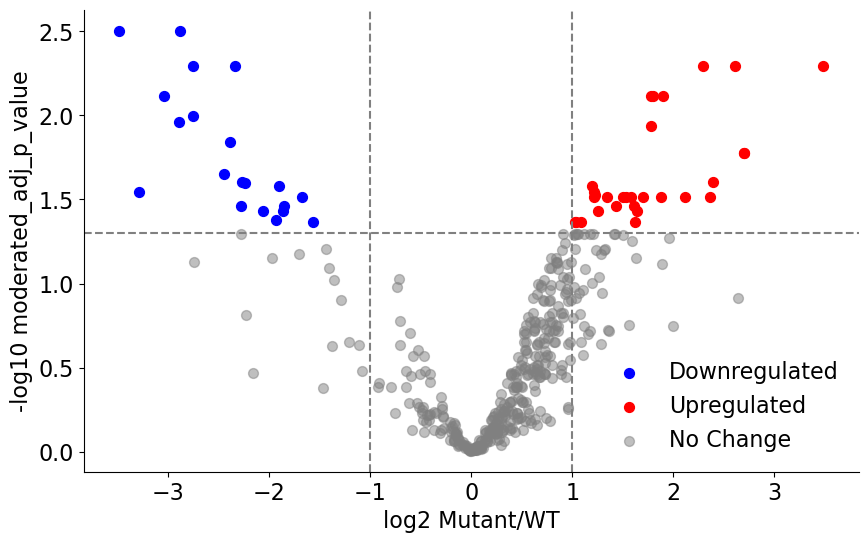

In [26]:
# remove all "adj_" if you want to plot he not adjusted p value
# Load the data_final_R.tsv file into a DataFrame
data_final = pd.read_csv("Output_R.tsv", sep="\t")

# Extract data for x and y axes, and protein IDs
x = data_final['Heavy_over_Light_logFC']
y = -np.log10(data_final['adj_p_values_Light_vs_Heavy'])
protein_ids = data_final['Protein.ID']
protein_descriptions = data_final['Protein.Description']

# Filter data points for downregulated proteins (log2 ratio < -1)
x_filtered_down = x[(x < -1) & (y > -np.log10(0.05))]
y_filtered_down = y[(x < -1) & (y > -np.log10(0.05))]
protein_ids_down = protein_ids[(x < -1) & (y > -np.log10(0.05))]
protein_descriptions_down = protein_descriptions[(x < -1) & (y > -np.log10(0.05))]

# Filter data points for upregulated proteins (log2 ratio > 1)
x_filtered_up = x[(x > 1) & (y > -np.log10(0.05))]
y_filtered_up = y[(x > 1) & (y > -np.log10(0.05))]
protein_ids_up = protein_ids[(x > 1) & (y > -np.log10(0.05))]
protein_descriptions_up = protein_descriptions[(x > 1) & (y > -np.log10(0.05))]

# Filter data points for proteins with no significant change
x_no_change = x[~((x < -1) & (y > -np.log10(0.05))) & ~((x > 1) & (y > -np.log10(0.05)))]
y_no_change = y[~((x < -1) & (y > -np.log10(0.05))) & ~((x > 1) & (y > -np.log10(0.05)))]
protein_ids_no_change = protein_ids[~((x < -1) & (y > -np.log10(0.05))) & ~((x > 1) & (y > -np.log10(0.05)))]
protein_descriptions_no_change = protein_descriptions[~((x < -1) & (y > -np.log10(0.05))) & ~((x > 1) & (y > -np.log10(0.05)))]

# Create a DataFrame for downregulated proteins
downregulated_data = pd.DataFrame({
    'x': x_filtered_down,
    'y': y_filtered_down,
    'protein_id': protein_ids_down,
    'protein_description': protein_descriptions_down,
    'change': 'Downregulated'
})

# Create a DataFrame for upregulated proteins
upregulated_data = pd.DataFrame({
    'x': x_filtered_up,
    'y': y_filtered_up,
    'protein_id': protein_ids_up,
    'protein_description': protein_descriptions_up,
    'change': 'Upregulated'
})

# Create a DataFrame for proteins with no significant change
no_change_data = pd.DataFrame({
    'x': x_no_change,
    'y': y_no_change,
    'protein_id': protein_ids_no_change,
    'protein_description': protein_descriptions_no_change,
    'change': 'No Change'
})

# Concatenate the DataFrames
combined_data = pd.concat([downregulated_data, upregulated_data, no_change_data])

# Add a column 'Signifikant' to data_final based on colors in the volcano plot
data_final['Significant'] = np.where((x < -1) & (y > -np.log10(0.05)), 'blue', np.where((x > 1) & (y > -np.log10(0.05)), 'red', 'not significant'))

# Create a color dictionary for mapping change types to colors
color_dict = {'Downregulated': 'blue', 'Upregulated': 'red', 'No Change': 'grey'}

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figure size as needed

# Plot data points for downregulated proteins with larger dots
ax.scatter(downregulated_data['x'], downregulated_data['y'], color=color_dict['Downregulated'], label='Downregulated', s=50)

# Plot data points for upregulated proteins with larger dots
ax.scatter(upregulated_data['x'], upregulated_data['y'], color=color_dict['Upregulated'], label='Upregulated', s=50)

# Plot data points for proteins with no significant change with larger dots
ax.scatter(no_change_data['x'], no_change_data['y'], color=color_dict['No Change'], label='No Change', s=50, alpha =0.5)

# Add horizontal line at significance threshold (-log10(0.05))
ax.axhline(y=-np.log10(0.05), linestyle='--', color='grey')

# Add vertical lines at log2 ratio thresholds (-1 and 1)
ax.axvline(x=-1, linestyle='--', color='grey')
ax.axvline(x=1, linestyle='--', color='grey')

# Set labels and title
ax.set_xlabel('log2 Mutant/WT', fontsize=16)
ax.set_ylabel('-log10 moderated_adj_p_value', fontsize=16)

# Customize y-axis tick labels
ax.tick_params(axis='y', labelsize=16) 
# Customize x-axis tick labels
ax.tick_params(axis='x', labelsize=16) 
# Add legend
ax.legend(fontsize = 16, frameon=False)

# Remove left spine
ax.spines['right'].set_visible(False)
# Remove top spine
ax.spines['top'].set_visible(False)

# Save the figure with adjusted bounding box
plt.savefig("Figures/Volcano_plot.pdf")

# Reorder columns in final_data DataFrame
data_final = data_final[['Peptide.Sequence', 'Modified.Peptide', 'Peptide.Length', 'Protein.ID', 'Protein.Description', 
                         'Start_Position_in_seq', 'End_Position_in_seq', 'Amino_acid_before_Sequence', 'X6_Amino_acids_before_Sequence', 
                         'cleavage_window','Start_Position_targetp2','Position_Difference', 'p_values_Light_vs_Heavy', 'adj_p_values_Light_vs_Heavy', 
                         'Heavy_over_Light_logFC', 'Significant'] + [col for col in data_final.columns if col not in 
                        ['Peptide.Sequence', 'Modified.Peptide', 'Peptide.Length', 'Protein.ID', 'Protein.Description', 
                         'Start_Position_in_seq', 'End_Position_in_seq', 'Amino_acid_before_Sequence', 'X6_Amino_acids_before_Sequence', 
                         'cleavage_window','Start_Position_targetp2','Position_Difference', 'p_values_Light_vs_Heavy', 
                         'adj_p_values_Light_vs_Heavy', 'Heavy_over_Light_logFC', 'Significant']]]
data_final.to_csv('Final_output.tsv', sep='\t', index=False)

# Show plot
plt.show()

In [ ]:
# Load the data_final_R.tsv file into a DataFrame
data_final = pd.read_csv("Output_R.tsv", sep="\t")

# Extract data for x and y axes, and protein IDs
x = data_final['Heavy_over_Light_logFC']
y = -np.log10(data_final['adj_p_values_Light_vs_Heavy'])
protein_ids = data_final['Protein.ID']
protein_descriptions = data_final['Protein.Description']

# Filter data points for downregulated proteins (log2 ratio < -1)
x_filtered_down = x[(x < -1) & (y > -np.log10(0.05))]
y_filtered_down = y[(x < -1) & (y > -np.log10(0.05))]
protein_ids_down = protein_ids[(x < -1) & (y > -np.log10(0.05))]
protein_descriptions_down = protein_descriptions[(x < -1) & (y > -np.log10(0.05))]

# Filter data points for upregulated proteins (log2 ratio > 1)
x_filtered_up = x[(x > 1) & (y > -np.log10(0.05))]
y_filtered_up = y[(x > 1) & (y > -np.log10(0.05))]
protein_ids_up = protein_ids[(x > 1) & (y > -np.log10(0.05))]
protein_descriptions_up = protein_descriptions[(x > 1) & (y > -np.log10(0.05))]

# Filter data points for proteins with no significant change
x_no_change = x[~((x < -1) & (y > -np.log10(0.05))) & ~((x > 1) & (y > -np.log10(0.05)))]
y_no_change = y[~((x < -1) & (y > -np.log10(0.05))) & ~((x > 1) & (y > -np.log10(0.05)))]
protein_ids_no_change = protein_ids[~((x < -1) & (y > -np.log10(0.05))) & ~((x > 1) & (y > -np.log10(0.05)))]
protein_descriptions_no_change = protein_descriptions[~((x < -1) & (y > -np.log10(0.05))) & ~((x > 1) & (y > -np.log10(0.05)))]

# Create a DataFrame for downregulated proteins
downregulated_data = pd.DataFrame({
    'x': x_filtered_down,
    'y': y_filtered_down,
    'protein_id': protein_ids_down,
    'protein_description': protein_descriptions_down,
    'change': 'Downregulated'
})

# Create a DataFrame for upregulated proteins
upregulated_data = pd.DataFrame({
    'x': x_filtered_up,
    'y': y_filtered_up,
    'protein_id': protein_ids_up,
    'protein_description': protein_descriptions_up,
    'change': 'Upregulated'
})

# Create a DataFrame for proteins with no significant change
no_change_data = pd.DataFrame({
    'x': x_no_change,
    'y': y_no_change,
    'protein_id': protein_ids_no_change,
    'protein_description': protein_descriptions_no_change,
    'change': 'No Change'
})


# Create an interactive volcano plot using Plotly Express
fig = px.scatter(combined_data, x='x', y='y', color='change', hover_name='protein_id',
                 hover_data={'protein_description': True},
                 labels={'x': 'Log2 Fold change Mutant/WT', 'y': '-log10(moderated_adj_p_value)'},
                 title='Volcano Plot', width=800, height=600,
                 color_discrete_map={'Downregulated': 'blue', 'Upregulated': 'red', 'No Change': 'grey'})

# Add horizontal line at significance threshold (-log10(0.05))
fig.add_hline(y=-np.log10(0.05), line_dash='dash', line_color='grey')

# Add vertical lines at log2 ratio thresholds (-1 and 1)
fig.add_vline(x=-1, line_dash='dash', line_color='grey')
fig.add_vline(x=1, line_dash='dash', line_color='grey')

# Save the plot as an interactive HTML file
fig.write_html("Figures/Volcano_plot_interactive.html")

# Show plot
fig.show()
